In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/GINECOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=155.1, y1=127.3
Page 1, Q1, A: Yellow pixels: 138
Page 1, Q1, A: Total non-white pixels: 605
Page 1, Q1, A: Yellow percentage: 22.8%


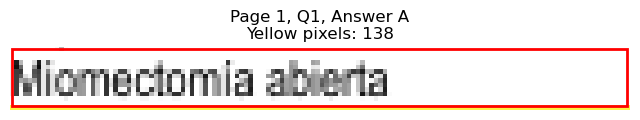

Page 1, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=183.1, y1=139.9
Page 1, Q1, B: Yellow pixels: 1691
Page 1, Q1, B: Total non-white pixels: 2158
Page 1, Q1, B: Yellow percentage: 78.4%


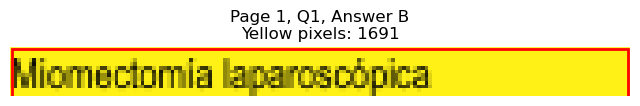

Page 1, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=443.9, y1=127.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 623
Page 1, Q1, C: Yellow percentage: 0.0%


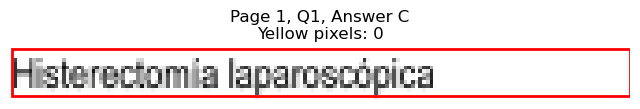

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=441.9, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 607
Page 1, Q1, D: Yellow percentage: 0.0%


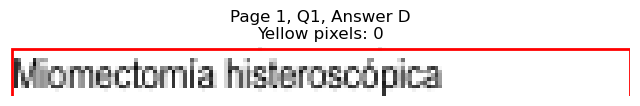


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=152.1, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 562
Page 1, Q2, A: Yellow percentage: 0.0%


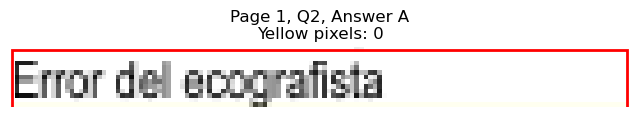

Page 1, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=156.1, y1=215.6
Page 1, Q2, B: Yellow pixels: 1448
Page 1, Q2, B: Total non-white pixels: 1946
Page 1, Q2, B: Yellow percentage: 74.4%


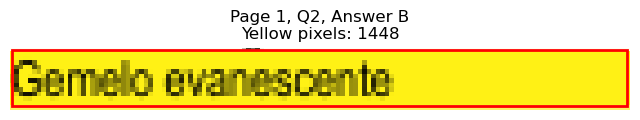

Page 1, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=400.7, y1=203.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 371
Page 1, Q2, C: Yellow percentage: 0.0%


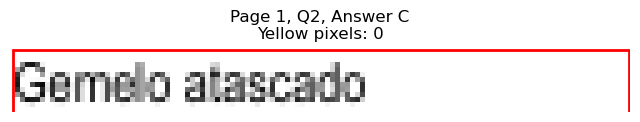

Page 1, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=398.2, y1=215.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 354
Page 1, Q2, D: Yellow percentage: 0.0%


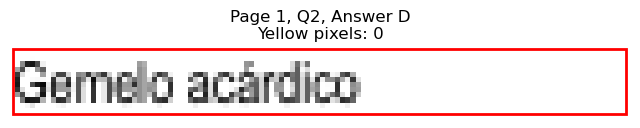


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=126.5, y1=266.1
Page 1, Q3, A: Yellow pixels: 1173
Page 1, Q3, A: Total non-white pixels: 1526
Page 1, Q3, A: Yellow percentage: 76.9%


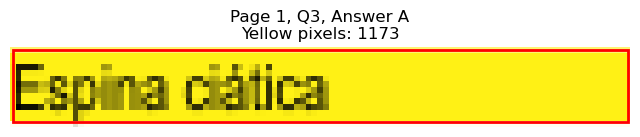

Page 1, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=147.0, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 503
Page 1, Q3, B: Yellow percentage: 0.0%


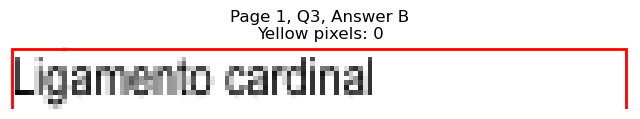

Page 1, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=379.1, y1=266.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 249
Page 1, Q3, C: Yellow percentage: 0.0%


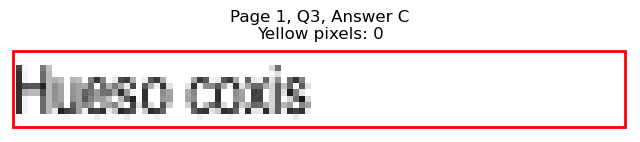

Page 1, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=419.8, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 428
Page 1, Q3, D: Yellow percentage: 0.0%


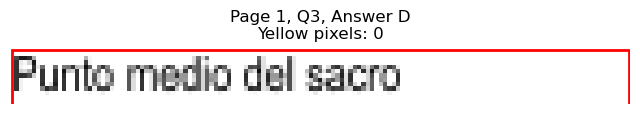


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=218.3, y1=316.7
Page 1, Q4, A: Yellow pixels: 2026
Page 1, Q4, A: Total non-white pixels: 2613
Page 1, Q4, A: Yellow percentage: 77.5%


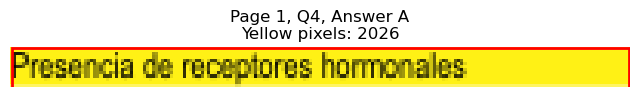

Page 1, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=209.8, y1=329.3
Page 1, Q4, B: Yellow pixels: 192
Page 1, Q4, B: Total non-white pixels: 902
Page 1, Q4, B: Yellow percentage: 21.3%


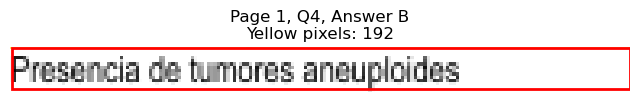

Page 1, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=398.7, y1=316.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 314
Page 1, Q4, C: Yellow percentage: 0.0%


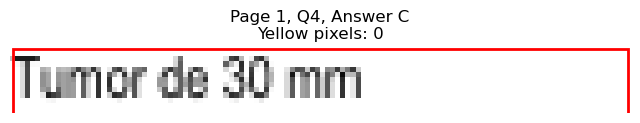

Page 1, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=505.1, y1=329.3
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 886
Page 1, Q4, D: Yellow percentage: 0.0%


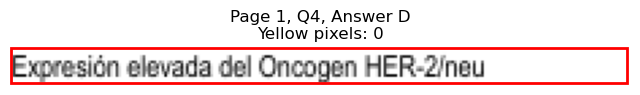


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=93.9, y1=367.2
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 118
Page 1, Q5, A: Yellow percentage: 0.0%


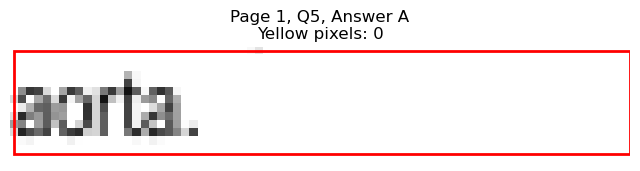

Page 1, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=100.9, y1=379.8
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 151
Page 1, Q5, B: Yellow percentage: 0.0%


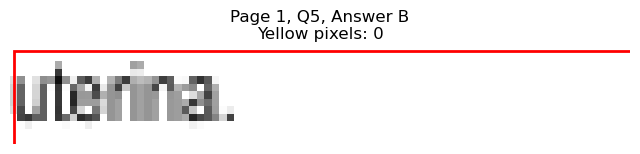

Page 1, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=382.7, y1=367.2
Page 1, Q5, C: Yellow pixels: 106
Page 1, Q5, C: Total non-white pixels: 350
Page 1, Q5, C: Yellow percentage: 30.3%


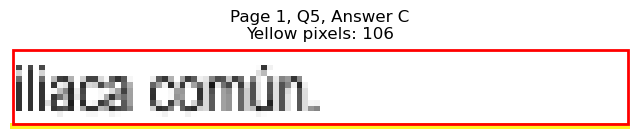

Page 1, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=383.2, y1=379.8
Page 1, Q5, D: Yellow pixels: 1195
Page 1, Q5, D: Total non-white pixels: 1391
Page 1, Q5, D: Yellow percentage: 85.9%


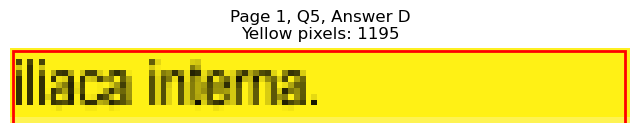


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=126.0, y1=455.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 318
Page 1, Q6, A: Yellow percentage: 0.0%


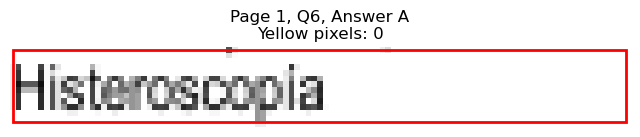

Page 1, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=171.1, y1=468.1
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 536
Page 1, Q6, B: Yellow percentage: 0.0%


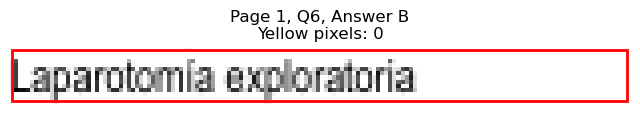

Page 1, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=399.3, y1=455.5
Page 1, Q6, C: Yellow pixels: 1301
Page 1, Q6, C: Total non-white pixels: 1722
Page 1, Q6, C: Yellow percentage: 75.6%


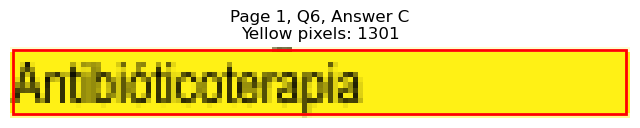

Page 1, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=394.3, y1=468.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 358
Page 1, Q6, D: Yellow percentage: 0.0%


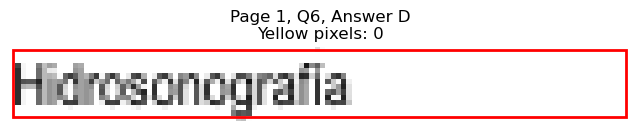


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=172.1, y1=531.2
Page 1, Q7, A: Yellow pixels: 1598
Page 1, Q7, A: Total non-white pixels: 2170
Page 1, Q7, A: Yellow percentage: 73.6%


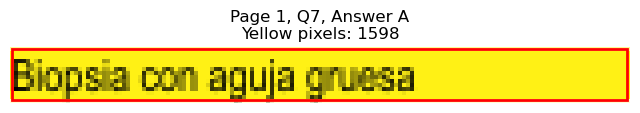

Page 1, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=236.8, y1=543.8
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 1052
Page 1, Q7, B: Yellow percentage: 0.0%


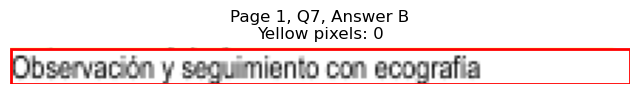

Page 1, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=388.3, y1=531.2
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 282
Page 1, Q7, C: Yellow percentage: 0.0%


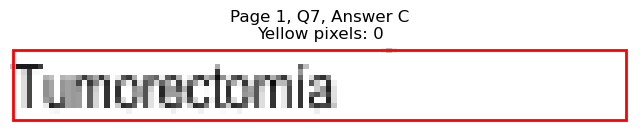

Page 1, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=399.3, y1=543.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 358
Page 1, Q7, D: Yellow percentage: 0.0%


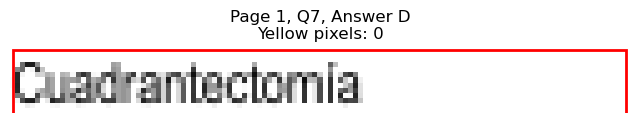


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=152.5, y1=581.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 419
Page 1, Q8, A: Yellow percentage: 0.0%


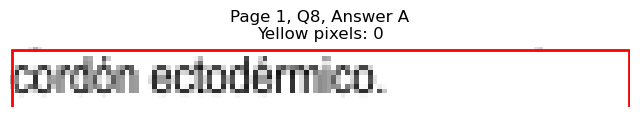

Page 1, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=136.5, y1=594.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 315
Page 1, Q8, B: Yellow percentage: 0.0%


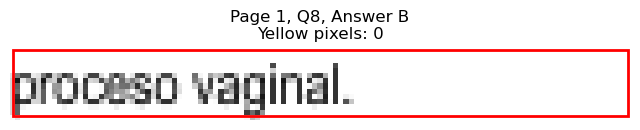

Page 1, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=398.8, y1=581.8
Page 1, Q8, C: Yellow pixels: 1
Page 1, Q8, C: Total non-white pixels: 499
Page 1, Q8, C: Yellow percentage: 0.2%


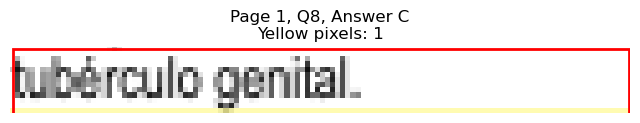

Page 1, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=413.8, y1=594.4
Page 1, Q8, D: Yellow pixels: 1324
Page 1, Q8, D: Total non-white pixels: 1918
Page 1, Q8, D: Yellow percentage: 69.0%


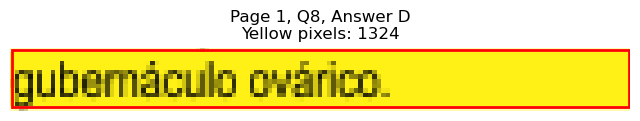


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=127.0, y1=657.5
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 265
Page 1, Q9, A: Yellow percentage: 0.0%


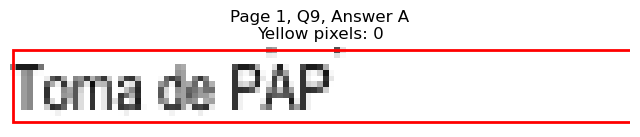

Page 1, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=143.5, y1=670.1
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 409
Page 1, Q9, B: Yellow percentage: 0.0%


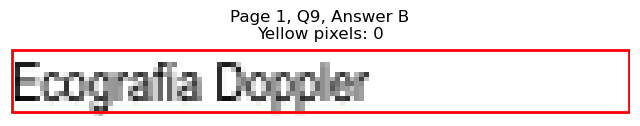

Page 1, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=414.3, y1=657.5
Page 1, Q9, C: Yellow pixels: 138
Page 1, Q9, C: Total non-white pixels: 575
Page 1, Q9, C: Yellow percentage: 24.0%


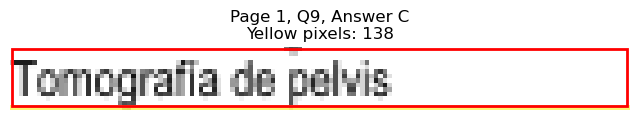

Page 1, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=419.8, y1=670.1
Page 1, Q9, D: Yellow pixels: 1496
Page 1, Q9, D: Total non-white pixels: 2002
Page 1, Q9, D: Yellow percentage: 74.7%


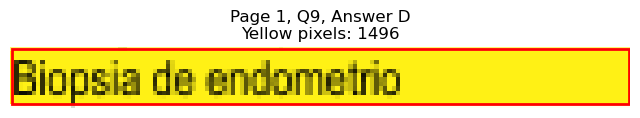


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=195.3, y1=720.6
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 605
Page 1, Q10, A: Yellow percentage: 0.0%


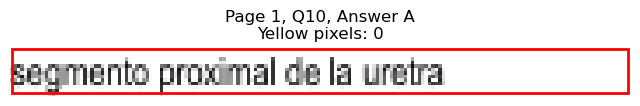

Page 1, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=124.5, y1=733.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 286
Page 1, Q10, B: Yellow percentage: 0.0%


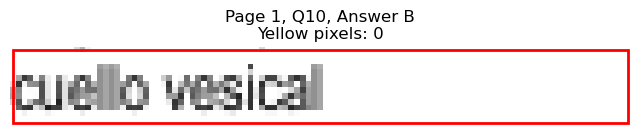

Page 1, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=444.9, y1=720.6
Page 1, Q10, C: Yellow pixels: 1732
Page 1, Q10, C: Total non-white pixels: 2352
Page 1, Q10, C: Yellow percentage: 73.6%


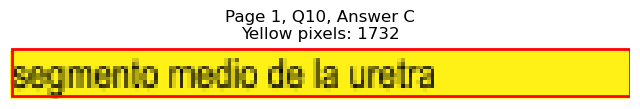

Page 1, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=439.0, y1=733.2
Page 1, Q10, D: Yellow pixels: 161
Page 1, Q10, D: Total non-white pixels: 750
Page 1, Q10, D: Yellow percentage: 21.5%


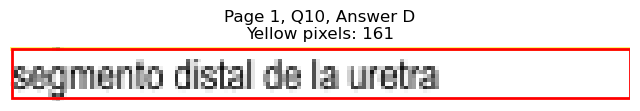


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=121.5, y1=139.9
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 263
Page 2, Q1, A: Yellow percentage: 0.0%


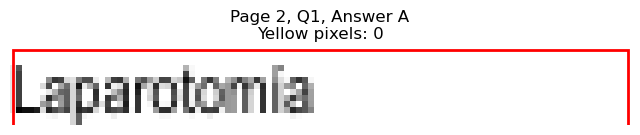

Page 2, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=166.1, y1=152.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 524
Page 2, Q1, B: Yellow percentage: 0.0%


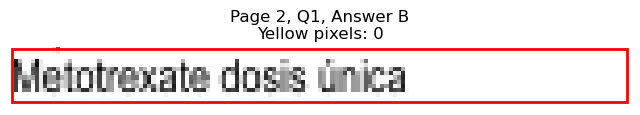

Page 2, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=502.4, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 898
Page 2, Q1, C: Yellow percentage: 0.0%


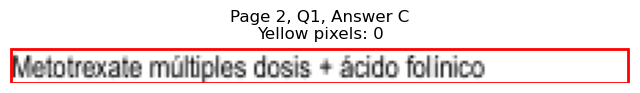

Page 2, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=384.8, y1=152.6
Page 2, Q1, D: Yellow pixels: 1192
Page 2, Q1, D: Total non-white pixels: 1512
Page 2, Q1, D: Yellow percentage: 78.8%


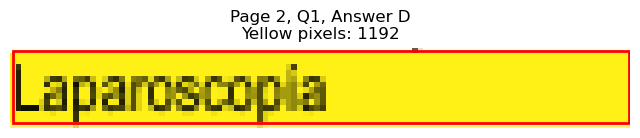


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=167.1, y1=215.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 516
Page 2, Q2, A: Yellow percentage: 0.0%


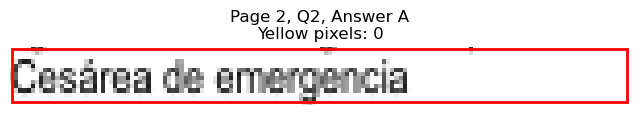

Page 2, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=109.5, y1=228.3
Page 2, Q2, B: Yellow pixels: 949
Page 2, Q2, B: Total non-white pixels: 1288
Page 2, Q2, B: Yellow percentage: 73.7%


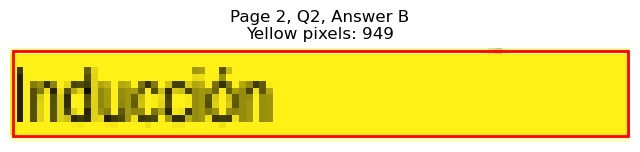

Page 2, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=415.3, y1=215.6
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 471
Page 2, Q2, C: Yellow percentage: 0.0%


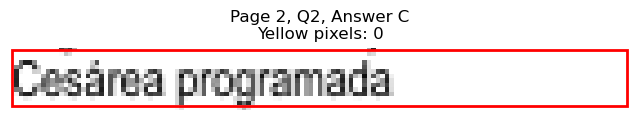

Page 2, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=385.7, y1=228.3
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 320
Page 2, Q2, D: Yellow percentage: 0.0%


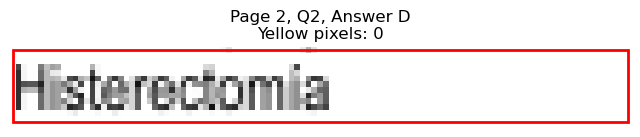


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=103.3, y1=266.1
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 177
Page 2, Q3, A: Yellow percentage: 0.0%


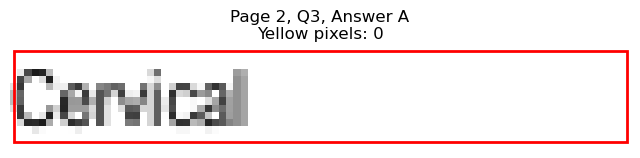

Page 2, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=113.4, y1=278.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 234
Page 2, Q3, B: Yellow percentage: 0.0%


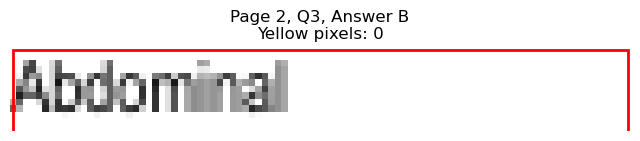

Page 2, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=361.1, y1=266.1
Page 2, Q3, C: Yellow pixels: 978
Page 2, Q3, C: Total non-white pixels: 1190
Page 2, Q3, C: Yellow percentage: 82.2%


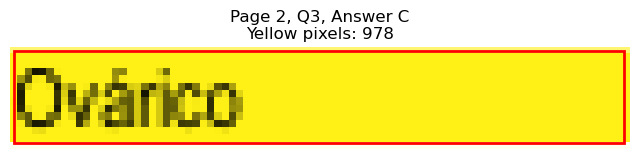

Page 2, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=390.2, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 429
Page 2, Q3, D: Yellow percentage: 0.0%


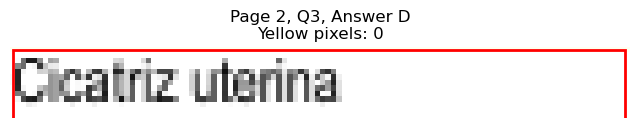


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=65.2, y1=329.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 44
Page 2, Q4, A: Yellow percentage: 0.0%


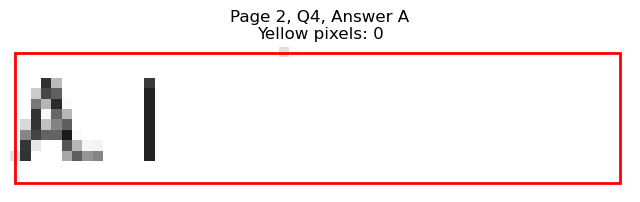

Page 2, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=79.3, y1=341.9
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 36
Page 2, Q4, B: Yellow percentage: 0.0%


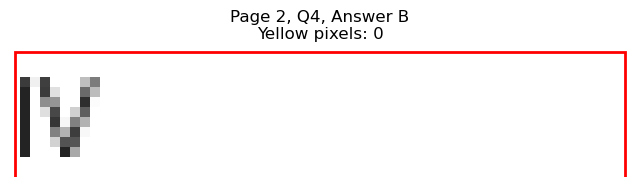

Page 2, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=324.4, y1=329.3
Page 2, Q4, C: Yellow pixels: 670
Page 2, Q4, C: Total non-white pixels: 840
Page 2, Q4, C: Yellow percentage: 79.8%


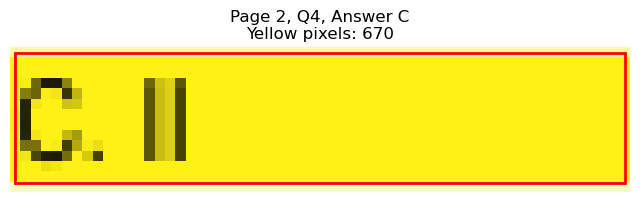

Page 2, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=337.6, y1=341.9
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 109
Page 2, Q4, D: Yellow percentage: 0.0%


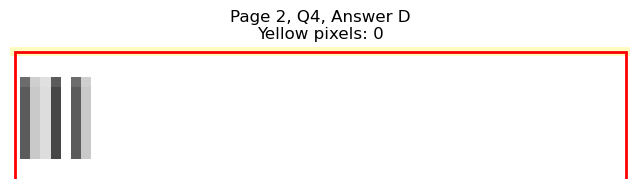


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=203.2, y1=405.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 689
Page 2, Q5, A: Yellow percentage: 0.0%


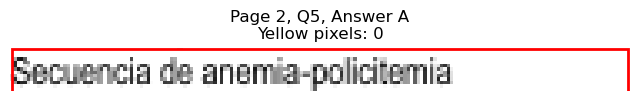

Page 2, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=209.2, y1=417.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 738
Page 2, Q5, B: Yellow percentage: 0.0%


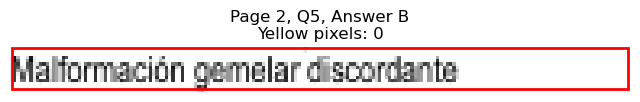

Page 2, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=398.7, y1=405.0
Page 2, Q5, C: Yellow pixels: 1314
Page 2, Q5, C: Total non-white pixels: 1586
Page 2, Q5, C: Yellow percentage: 82.8%


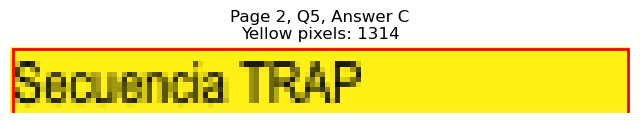

Page 2, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=414.3, y1=417.6
Page 2, Q5, D: Yellow pixels: 138
Page 2, Q5, D: Total non-white pixels: 581
Page 2, Q5, D: Yellow percentage: 23.8%


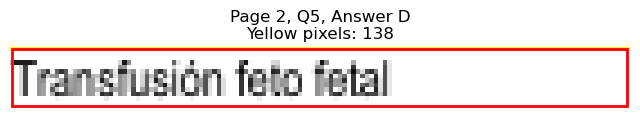


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=141.0, y1=493.4
Page 2, Q6, A: Yellow pixels: 124
Page 2, Q6, A: Total non-white pixels: 470
Page 2, Q6, A: Yellow percentage: 26.4%


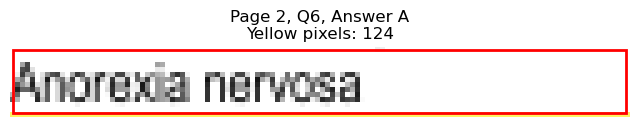

Page 2, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=199.7, y1=506.0
Page 2, Q6, B: Yellow pixels: 1888
Page 2, Q6, B: Total non-white pixels: 2368
Page 2, Q6, B: Yellow percentage: 79.7%


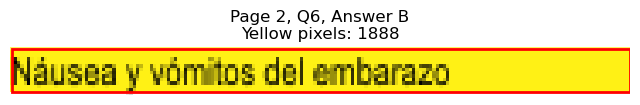

Page 2, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=419.3, y1=493.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 498
Page 2, Q6, C: Yellow percentage: 0.0%


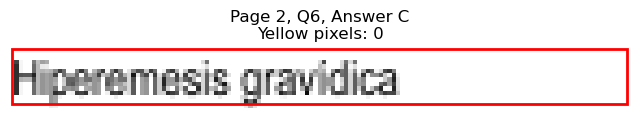

Page 2, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=432.8, y1=506.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 563
Page 2, Q6, D: Yellow percentage: 0.0%


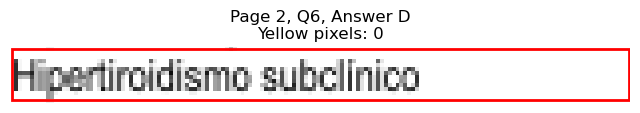


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=88.3, y1=556.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 106
Page 2, Q7, A: Yellow percentage: 0.0%


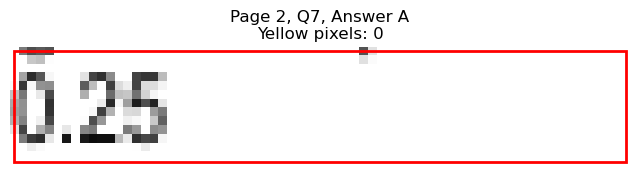

Page 2, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=83.4, y1=569.2
Page 2, Q7, B: Yellow pixels: 813
Page 2, Q7, B: Total non-white pixels: 924
Page 2, Q7, B: Yellow percentage: 88.0%


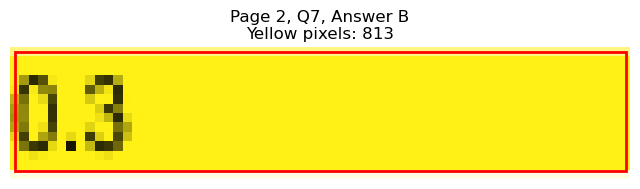

Page 2, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=342.7, y1=556.4
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 64
Page 2, Q7, C: Yellow percentage: 0.0%


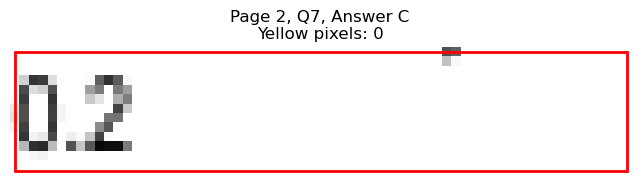

Page 2, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=347.6, y1=569.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 86
Page 2, Q7, D: Yellow percentage: 0.0%


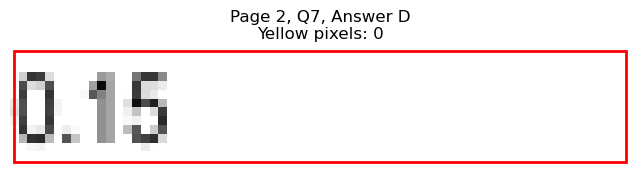


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=222.3, y1=632.3
Page 2, Q8, A: Yellow pixels: 1834
Page 2, Q8, A: Total non-white pixels: 2870
Page 2, Q8, A: Yellow percentage: 63.9%


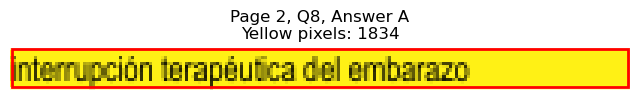

Page 2, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=145.1, y1=644.9
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 508
Page 2, Q8, B: Yellow percentage: 0.0%


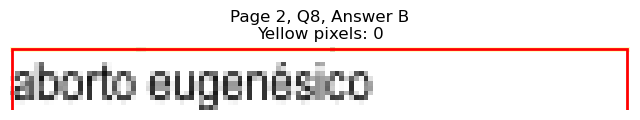

Page 2, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=379.9, y1=632.3
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 257
Page 2, Q8, C: Yellow percentage: 0.0%


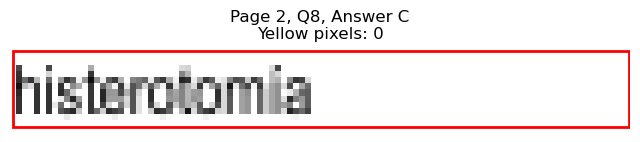

Page 2, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=486.6, y1=644.9
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 792
Page 2, Q8, D: Yellow percentage: 0.0%


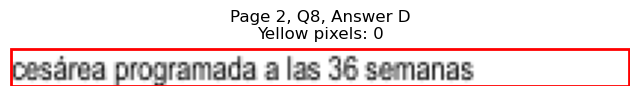


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=258.9, y1=720.6
Page 2, Q9, A: Yellow pixels: 213
Page 2, Q9, A: Total non-white pixels: 1128
Page 2, Q9, A: Yellow percentage: 18.9%


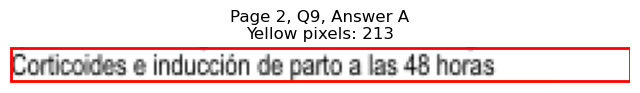

Page 2, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=205.8, y1=733.2
Page 2, Q9, B: Yellow pixels: 1875
Page 2, Q9, B: Total non-white pixels: 2632
Page 2, Q9, B: Yellow percentage: 71.2%


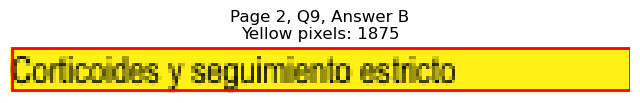

Page 2, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=467.5, y1=720.6
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 659
Page 2, Q9, C: Yellow percentage: 0.0%


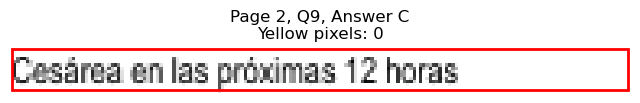

Page 2, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=455.9, y1=733.2
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 646
Page 2, Q9, D: Yellow percentage: 0.0%


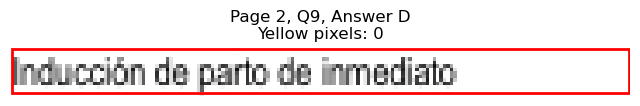


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=190.2, y1=114.7
Page 3, Q1, A: Yellow pixels: 1773
Page 3, Q1, A: Total non-white pixels: 2249
Page 3, Q1, A: Yellow percentage: 78.8%


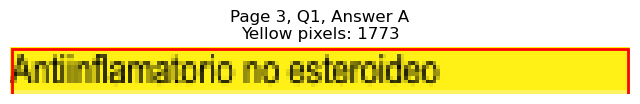

Page 3, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=193.7, y1=127.3
Page 3, Q1, B: Yellow pixels: 176
Page 3, Q1, B: Total non-white pixels: 793
Page 3, Q1, B: Yellow percentage: 22.2%


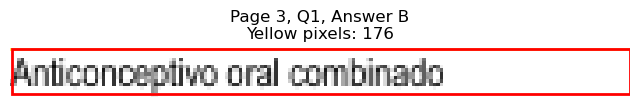

Page 3, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=415.3, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 467
Page 3, Q1, C: Yellow percentage: 0.0%


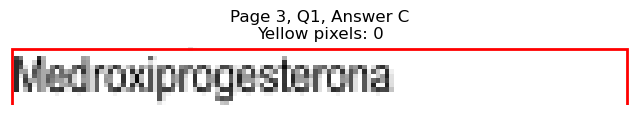

Page 3, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=413.8, y1=127.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 443
Page 3, Q1, D: Yellow percentage: 0.0%


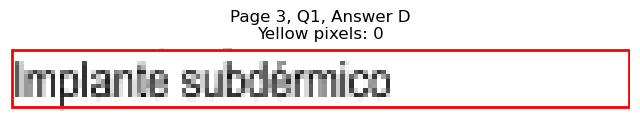


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=153.0, y1=203.0
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 558
Page 3, Q2, A: Yellow percentage: 0.0%


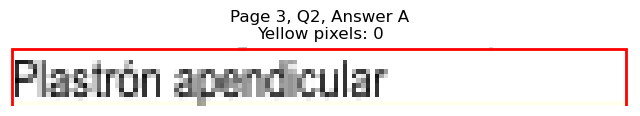

Page 3, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=157.2, y1=215.6
Page 3, Q2, B: Yellow pixels: 1472
Page 3, Q2, B: Total non-white pixels: 1960
Page 3, Q2, B: Yellow percentage: 75.1%


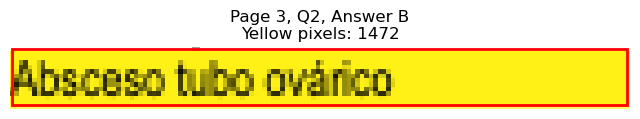

Page 3, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=429.9, y1=203.0
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 501
Page 3, Q2, C: Yellow percentage: 0.0%


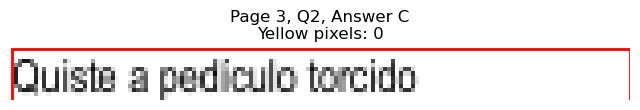

Page 3, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=376.7, y1=215.6
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 261
Page 3, Q2, D: Yellow percentage: 0.0%


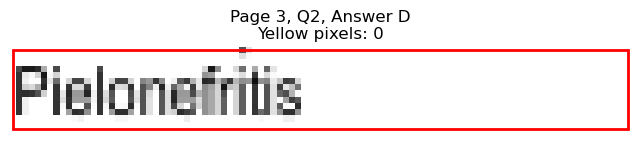


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=139.0, y1=278.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 338
Page 3, Q3, A: Yellow percentage: 0.0%


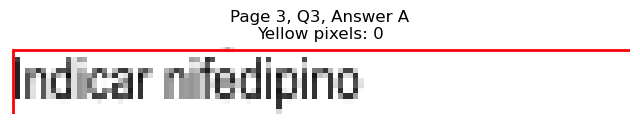

Page 3, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=214.2, y1=291.5
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 779
Page 3, Q3, B: Yellow percentage: 0.0%


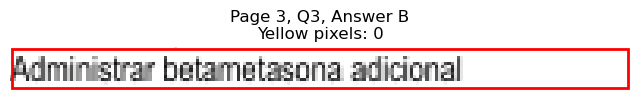

Page 3, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=391.7, y1=278.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 333
Page 3, Q3, C: Yellow percentage: 0.0%


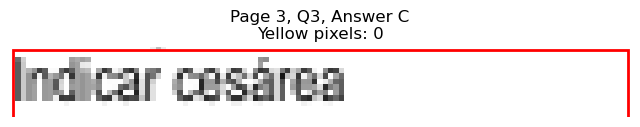

Page 3, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=434.8, y1=291.5
Page 3, Q3, D: Yellow pixels: 1644
Page 3, Q3, D: Total non-white pixels: 2212
Page 3, Q3, D: Yellow percentage: 74.3%


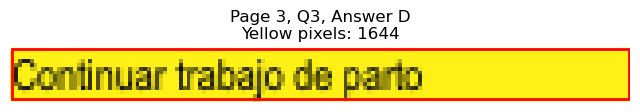


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=113.9, y1=341.9
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 237
Page 3, Q4, A: Yellow percentage: 0.0%


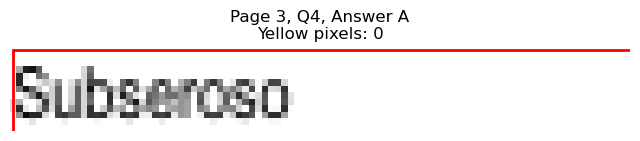

Page 3, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=111.4, y1=354.6
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 212
Page 3, Q4, B: Yellow percentage: 0.0%


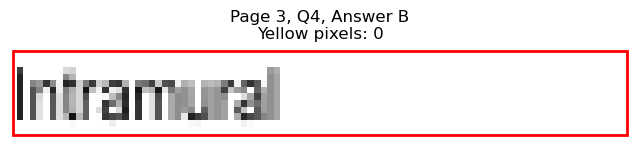

Page 3, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=377.7, y1=341.9
Page 3, Q4, C: Yellow pixels: 1130
Page 3, Q4, C: Total non-white pixels: 1313
Page 3, Q4, C: Yellow percentage: 86.1%


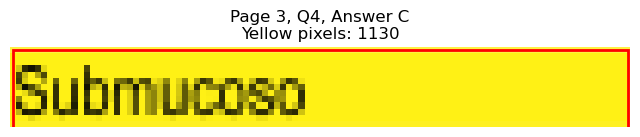

Page 3, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=374.7, y1=354.6
Page 3, Q4, D: Yellow pixels: 98
Page 3, Q4, D: Total non-white pixels: 333
Page 3, Q4, D: Yellow percentage: 29.4%


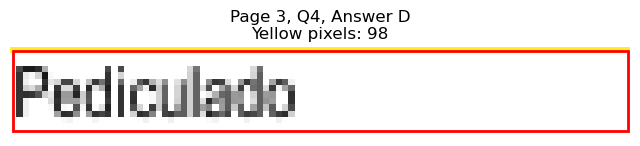


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=142.1, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 382
Page 3, Q5, A: Yellow percentage: 0.0%


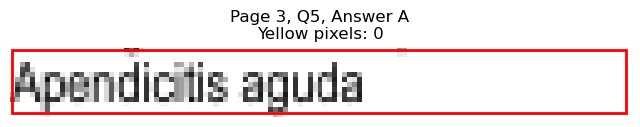

Page 3, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=166.1, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 508
Page 3, Q5, B: Yellow percentage: 0.0%


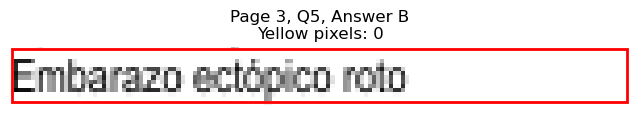

Page 3, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=411.8, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 397
Page 3, Q5, C: Yellow percentage: 0.0%


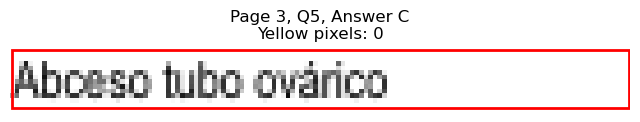

Page 3, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=421.9, y1=430.3
Page 3, Q5, D: Yellow pixels: 1388
Page 3, Q5, D: Total non-white pixels: 2030
Page 3, Q5, D: Yellow percentage: 68.4%


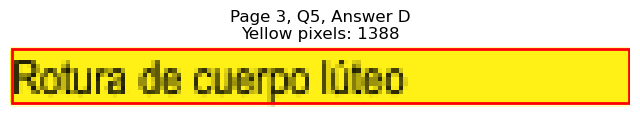


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=154.1, y1=480.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 421
Page 3, Q6, A: Yellow percentage: 0.0%


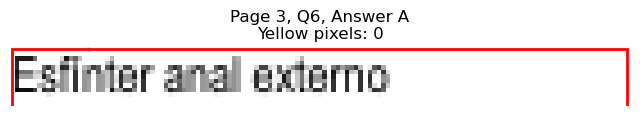

Page 3, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=170.7, y1=493.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 510
Page 3, Q6, B: Yellow percentage: 0.0%


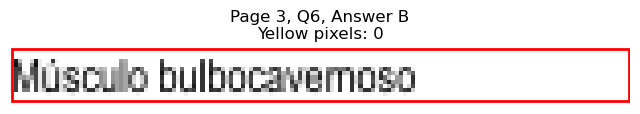

Page 3, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=386.2, y1=480.7
Page 3, Q6, C: Yellow pixels: 1200
Page 3, Q6, C: Total non-white pixels: 1430
Page 3, Q6, C: Yellow percentage: 83.9%


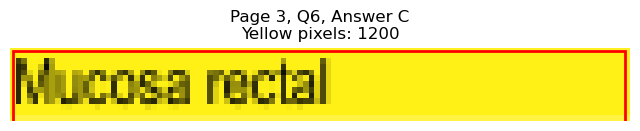

Page 3, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=392.7, y1=493.4
Page 3, Q6, D: Yellow pixels: 116
Page 3, Q6, D: Total non-white pixels: 457
Page 3, Q6, D: Yellow percentage: 25.4%


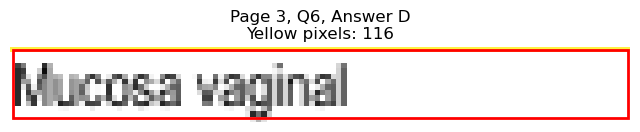


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=124.9, y1=543.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 275
Page 3, Q7, A: Yellow percentage: 0.0%


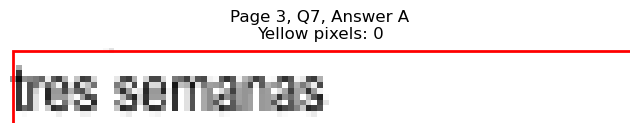

Page 3, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=135.0, y1=556.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 327
Page 3, Q7, B: Yellow percentage: 0.0%


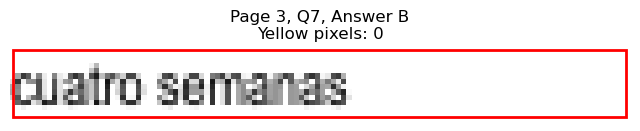

Page 3, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=342.7, y1=543.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 135
Page 3, Q7, C: Yellow percentage: 0.0%


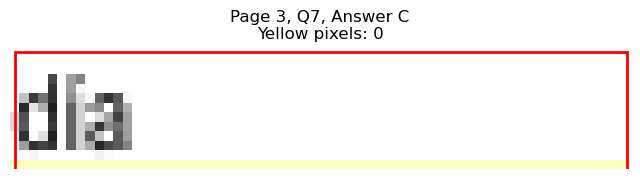

Page 3, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=362.1, y1=556.4
Page 3, Q7, D: Yellow pixels: 988
Page 3, Q7, D: Total non-white pixels: 1204
Page 3, Q7, D: Yellow percentage: 82.1%


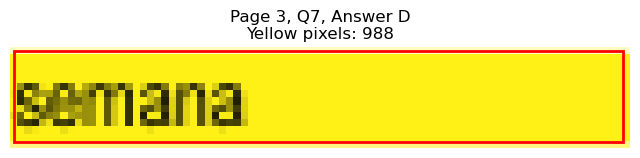


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=181.1, y1=607.0
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 571
Page 3, Q8, A: Yellow percentage: 0.0%


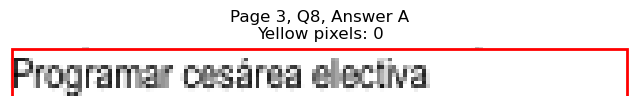

Page 3, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=187.2, y1=619.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 629
Page 3, Q8, B: Yellow percentage: 0.0%


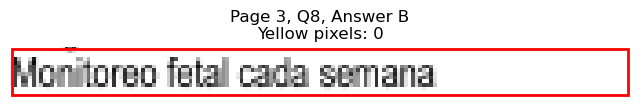

Page 3, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=447.4, y1=607.0
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 776
Page 3, Q8, C: Yellow percentage: 0.0%


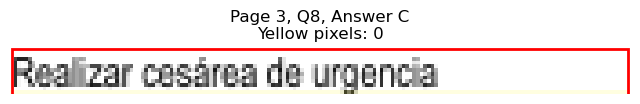

Page 3, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=460.4, y1=619.6
Page 3, Q8, D: Yellow pixels: 1923
Page 3, Q8, D: Total non-white pixels: 2576
Page 3, Q8, D: Yellow percentage: 74.7%


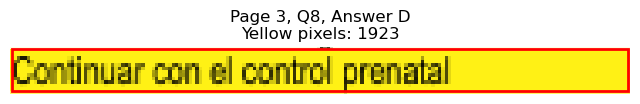


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=56.6, y0=670.1, x1=65.2, y1=682.7
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 68
Page 3, Q9, A: Yellow percentage: 0.0%


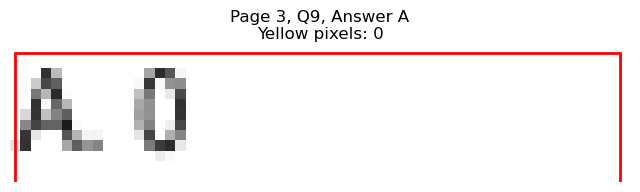

Page 3, Q9 - B: Detected box: x0=56.6, y0=682.7, x1=65.2, y1=695.3
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 69
Page 3, Q9, B: Yellow percentage: 0.0%


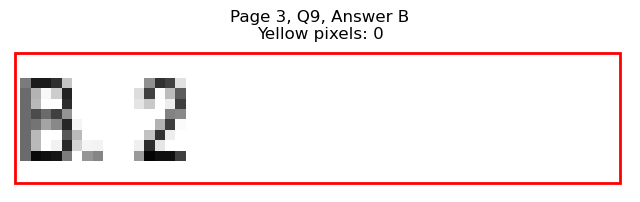

Page 3, Q9 - C: Detected box: x0=315.4, y0=670.1, x1=324.4, y1=682.7
Page 3, Q9, C: Yellow pixels: 743
Page 3, Q9, C: Total non-white pixels: 780
Page 3, Q9, C: Yellow percentage: 95.3%


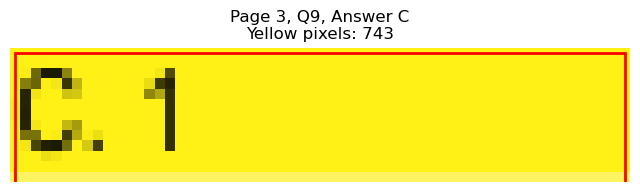

Page 3, Q9 - D: Detected box: x0=315.4, y0=682.7, x1=324.4, y1=695.3
Page 3, Q9, D: Yellow pixels: 60
Page 3, Q9, D: Total non-white pixels: 130
Page 3, Q9, D: Yellow percentage: 46.2%


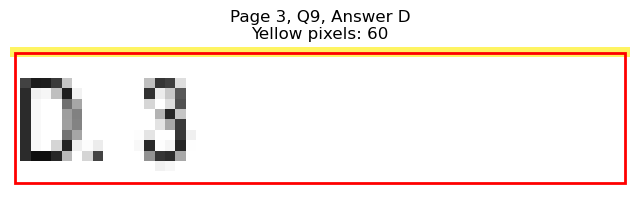


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=96.9, y1=758.4
Page 3, Q10, A: Yellow pixels: 908
Page 3, Q10, A: Total non-white pixels: 1106
Page 3, Q10, A: Yellow percentage: 82.1%


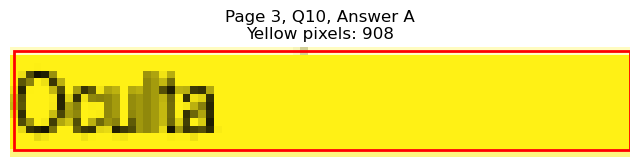

Page 3, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=92.4, y1=771.2
Page 3, Q10, B: Yellow pixels: 75
Page 3, Q10, B: Total non-white pixels: 212
Page 3, Q10, B: Yellow percentage: 35.4%


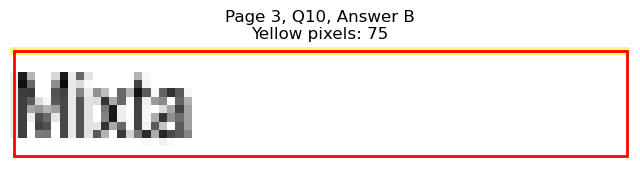

Page 3, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=372.7, y1=758.4
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 234
Page 3, Q10, C: Yellow percentage: 0.0%


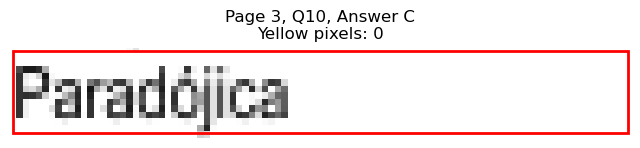

Page 3, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=378.7, y1=771.2
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 243
Page 3, Q10, D: Yellow percentage: 0.0%


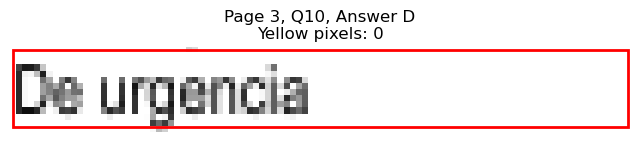


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=115.0, y1=114.7
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 235
Page 4, Q1, A: Yellow percentage: 0.0%


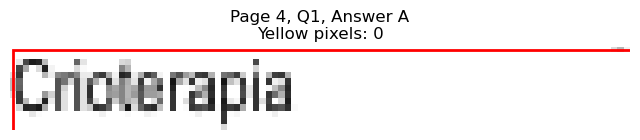

Page 4, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=115.5, y1=127.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 240
Page 4, Q1, B: Yellow percentage: 0.0%


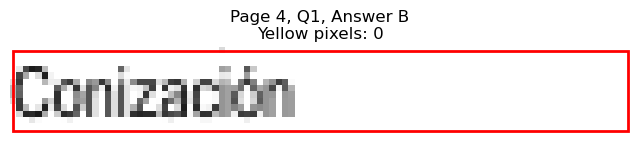

Page 4, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=411.3, y1=114.7
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 559
Page 4, Q1, C: Yellow percentage: 0.0%


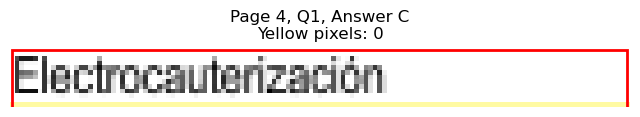

Page 4, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=438.9, y1=127.3
Page 4, Q1, D: Yellow pixels: 1510
Page 4, Q1, D: Total non-white pixels: 2268
Page 4, Q1, D: Yellow percentage: 66.6%


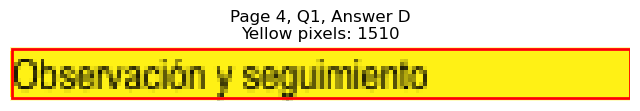


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=153.0, y1=165.2
Page 4, Q2, A: Yellow pixels: 1452
Page 4, Q2, A: Total non-white pixels: 1904
Page 4, Q2, A: Yellow percentage: 76.3%


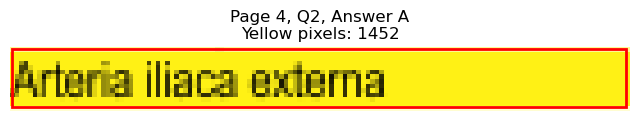

Page 4, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=150.5, y1=177.8
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 515
Page 4, Q2, B: Yellow percentage: 0.0%


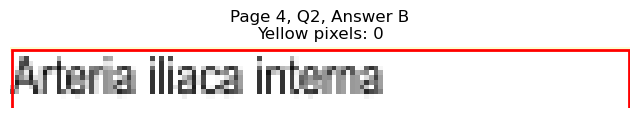

Page 4, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=407.8, y1=165.2
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 384
Page 4, Q2, C: Yellow percentage: 0.0%


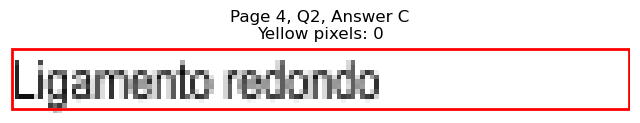

Page 4, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=449.5, y1=177.8
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 618
Page 4, Q2, D: Yellow percentage: 0.0%


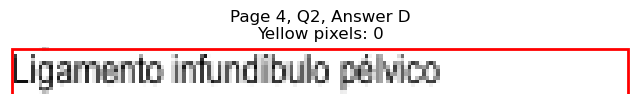


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=173.7, y1=228.3
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 546
Page 4, Q3, A: Yellow percentage: 0.0%


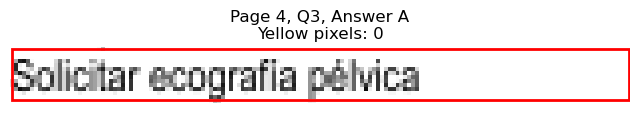

Page 4, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=176.1, y1=240.9
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 500
Page 4, Q3, B: Yellow percentage: 0.0%


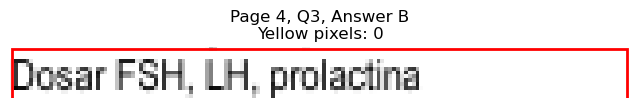

Page 4, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=441.9, y1=228.3
Page 4, Q3, C: Yellow pixels: 165
Page 4, Q3, C: Total non-white pixels: 737
Page 4, Q3, C: Yellow percentage: 22.4%


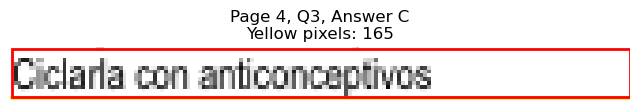

Page 4, Q3 - D: Detected box: x0=327.5, y0=114.6, x1=380.8, y1=127.3
Page 4, Q3, D: Yellow pixels: 834
Page 4, Q3, D: Total non-white pixels: 1456
Page 4, Q3, D: Yellow percentage: 57.3%


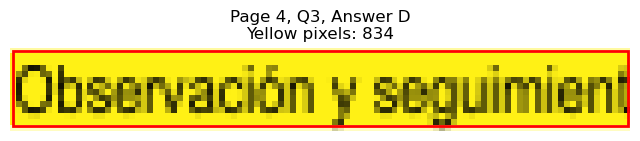


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=168.6, y1=304.1
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 494
Page 4, Q4, A: Yellow percentage: 0.0%


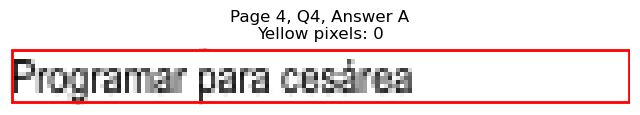

Page 4, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=167.1, y1=316.7
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 503
Page 4, Q4, B: Yellow percentage: 0.0%


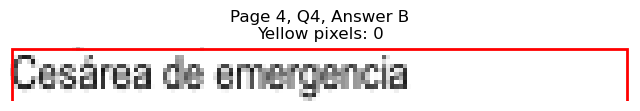

Page 4, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=436.4, y1=304.1
Page 4, Q4, C: Yellow pixels: 1644
Page 4, Q4, C: Total non-white pixels: 2240
Page 4, Q4, C: Yellow percentage: 73.4%


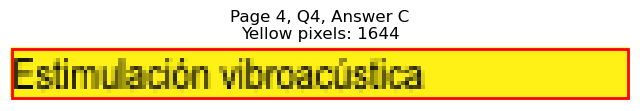

Page 4, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=389.7, y1=316.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 426
Page 4, Q4, D: Yellow percentage: 0.0%


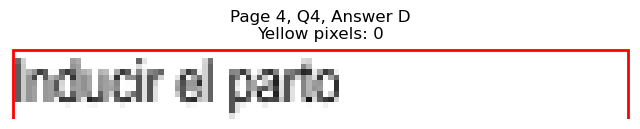


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=129.0, y1=392.4
Page 4, Q5, A: Yellow pixels: 112
Page 4, Q5, A: Total non-white pixels: 407
Page 4, Q5, A: Yellow percentage: 27.5%


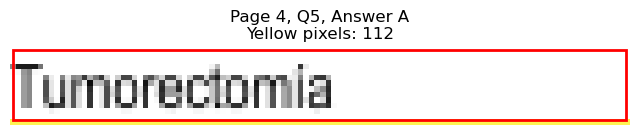

Page 4, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=172.1, y1=405.0
Page 4, Q5, B: Yellow pixels: 1598
Page 4, Q5, B: Total non-white pixels: 2015
Page 4, Q5, B: Yellow percentage: 79.3%


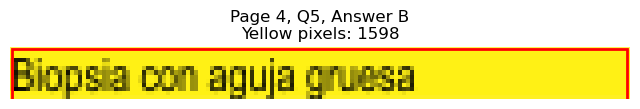

Page 4, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=399.3, y1=392.4
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 361
Page 4, Q5, C: Yellow percentage: 0.0%


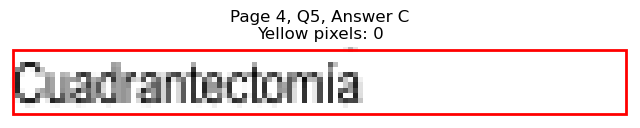

Page 4, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=381.7, y1=405.0
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 297
Page 4, Q5, D: Yellow percentage: 0.0%


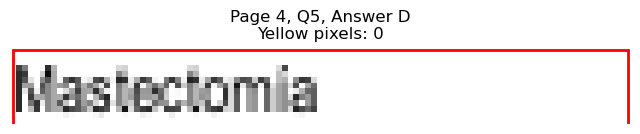


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=127.9, y1=468.1
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 292
Page 4, Q6, A: Yellow percentage: 0.0%


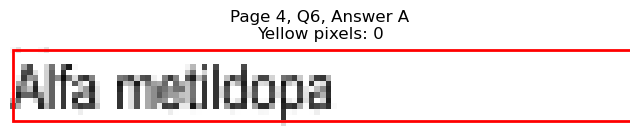

Page 4, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=110.9, y1=480.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 224
Page 4, Q6, B: Yellow percentage: 0.0%


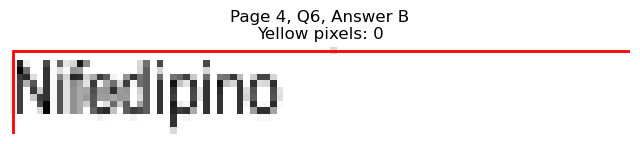

Page 4, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=412.7, y1=468.1
Page 4, Q6, C: Yellow pixels: 1453
Page 4, Q6, C: Total non-white pixels: 1904
Page 4, Q6, C: Yellow percentage: 76.3%


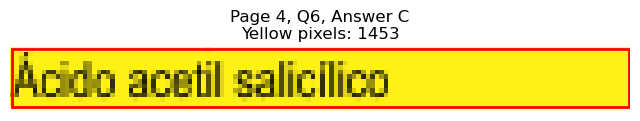

Page 4, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=374.2, y1=480.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 317
Page 4, Q6, D: Yellow percentage: 0.0%


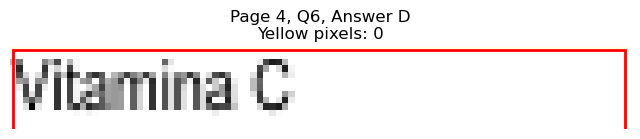


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=146.5, y1=531.2
Page 4, Q7, A: Yellow pixels: 129
Page 4, Q7, A: Total non-white pixels: 526
Page 4, Q7, A: Yellow percentage: 24.5%


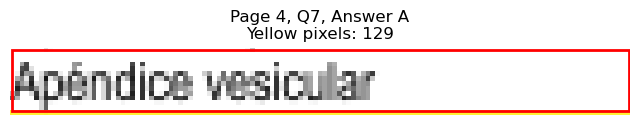

Page 4, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=107.4, y1=543.8
Page 4, Q7, B: Yellow pixels: 1016
Page 4, Q7, B: Total non-white pixels: 1170
Page 4, Q7, B: Yellow percentage: 86.8%


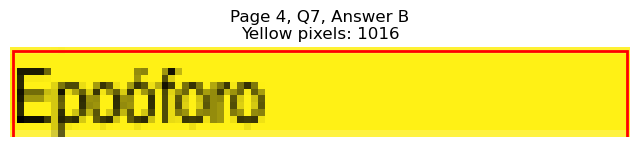

Page 4, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=415.9, y1=531.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 497
Page 4, Q7, C: Yellow percentage: 0.0%


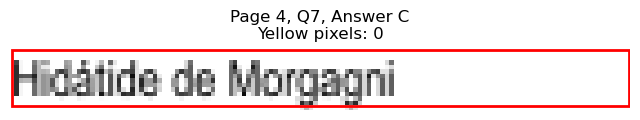

Page 4, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=414.3, y1=543.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 426
Page 4, Q7, D: Yellow percentage: 0.0%


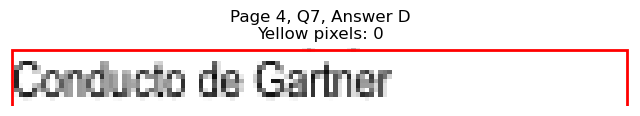


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=172.1, y1=619.6
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 557
Page 4, Q8, A: Yellow percentage: 0.0%


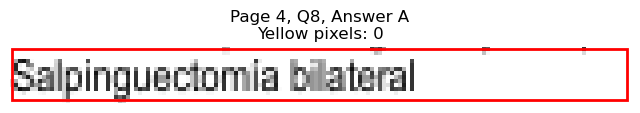

Page 4, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=297.0, y1=632.3
Page 4, Q8, B: Yellow pixels: 280
Page 4, Q8, B: Total non-white pixels: 1418
Page 4, Q8, B: Yellow percentage: 19.7%


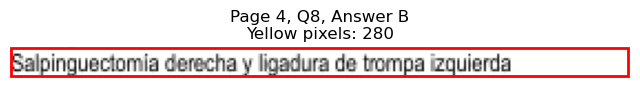

Page 4, Q8 - C: Detected box: x0=68.8, y0=632.2, x1=133.5, y1=644.9
Page 4, Q8, C: Yellow pixels: 1225
Page 4, Q8, C: Total non-white pixels: 1508
Page 4, Q8, C: Yellow percentage: 81.2%


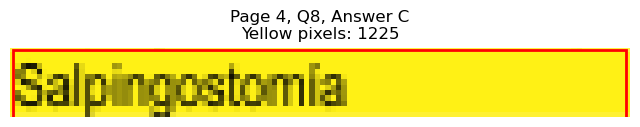

Page 4, Q8 - D: Detected box: x0=68.8, y0=644.9, x1=173.7, y1=657.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 580
Page 4, Q8, D: Yellow percentage: 0.0%


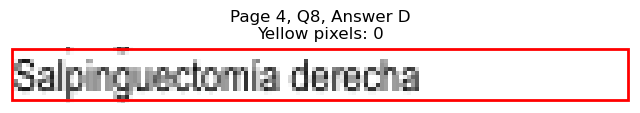


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=56.6, y0=720.6, x1=65.2, y1=733.2
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 55
Page 4, Q9, A: Yellow percentage: 0.0%


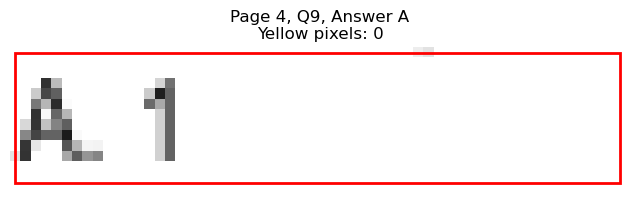

Page 4, Q9 - B: Detected box: x0=68.3, y0=733.2, x1=83.4, y1=745.8
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 68
Page 4, Q9, B: Yellow percentage: 0.0%


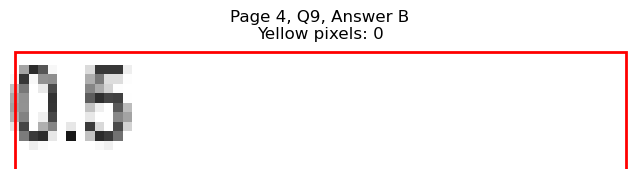

Page 4, Q9 - C: Detected box: x0=327.5, y0=720.6, x1=342.7, y1=733.2
Page 4, Q9, C: Yellow pixels: 822
Page 4, Q9, C: Total non-white pixels: 924
Page 4, Q9, C: Yellow percentage: 89.0%


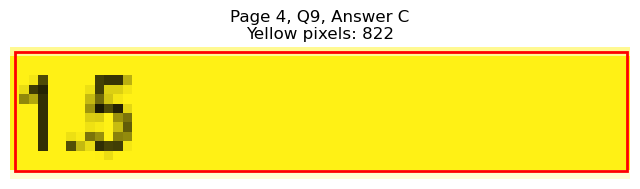

Page 4, Q9 - D: Detected box: x0=315.4, y0=733.2, x1=324.4, y1=745.8
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 126
Page 4, Q9, D: Yellow percentage: 0.0%


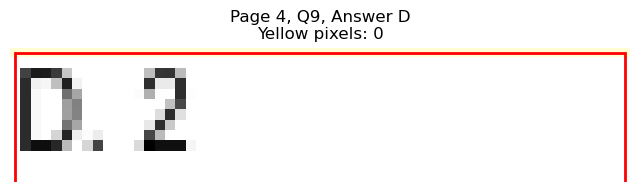


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=141.0, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 318
Page 5, Q1, A: Yellow percentage: 0.0%


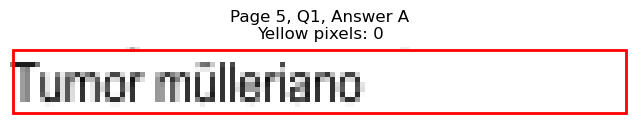

Page 5, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=132.5, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 314
Page 5, Q1, B: Yellow percentage: 0.0%


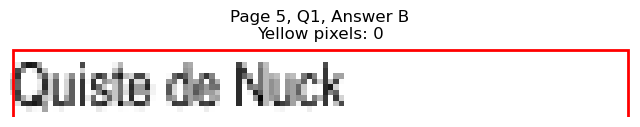

Page 5, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=400.7, y1=127.3
Page 5, Q1, C: Yellow pixels: 124
Page 5, Q1, C: Total non-white pixels: 499
Page 5, Q1, C: Yellow percentage: 24.8%


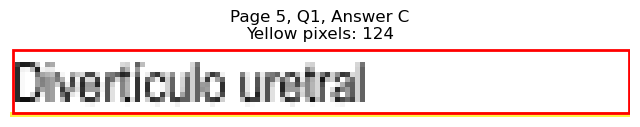

Page 5, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=396.8, y1=139.9
Page 5, Q1, D: Yellow pixels: 1305
Page 5, Q1, D: Total non-white pixels: 1560
Page 5, Q1, D: Yellow percentage: 83.7%


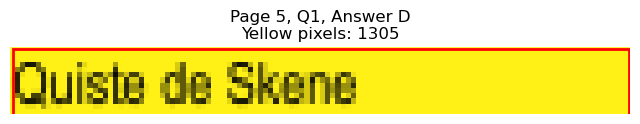


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=119.4, y1=203.0
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 370
Page 5, Q2, A: Yellow percentage: 0.0%


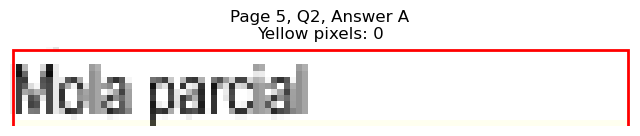

Page 5, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=127.0, y1=215.6
Page 5, Q2, B: Yellow pixels: 1176
Page 5, Q2, B: Total non-white pixels: 1526
Page 5, Q2, B: Yellow percentage: 77.1%


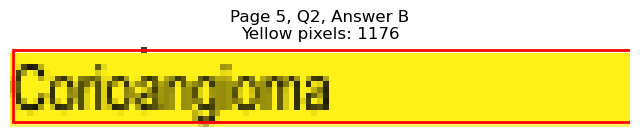

Page 5, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=420.8, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 487
Page 5, Q2, C: Yellow percentage: 0.0%


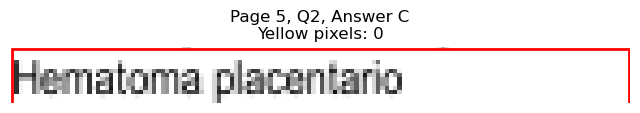

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=374.2, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 219
Page 5, Q2, D: Yellow percentage: 0.0%


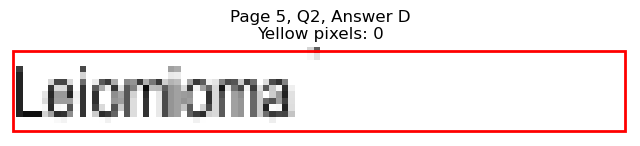


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=150.0, y1=278.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 399
Page 5, Q3, A: Yellow percentage: 0.0%


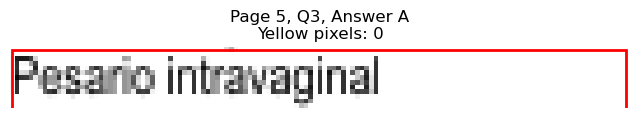

Page 5, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=157.1, y1=291.5
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 443
Page 5, Q3, B: Yellow percentage: 0.0%


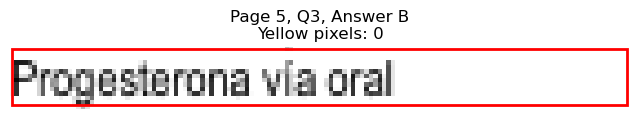

Page 5, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=416.8, y1=278.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 454
Page 5, Q3, C: Yellow percentage: 0.0%


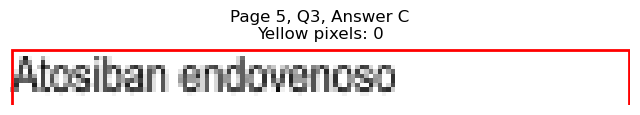

Page 5, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=396.2, y1=291.5
Page 5, Q3, D: Yellow pixels: 1297
Page 5, Q3, D: Total non-white pixels: 1680
Page 5, Q3, D: Yellow percentage: 77.2%


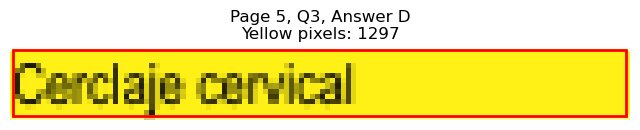


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=139.5, y1=329.3
Page 5, Q4, A: Yellow pixels: 1169
Page 5, Q4, A: Total non-white pixels: 1708
Page 5, Q4, A: Yellow percentage: 68.4%


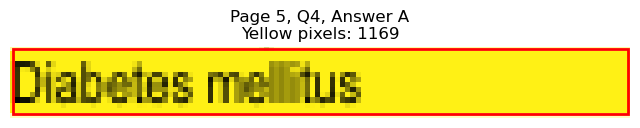

Page 5, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=125.5, y1=341.9
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 420
Page 5, Q4, B: Yellow percentage: 0.0%


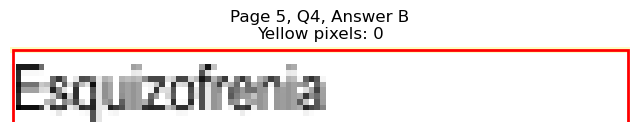

Page 5, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=394.7, y1=329.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 346
Page 5, Q4, C: Yellow percentage: 0.0%


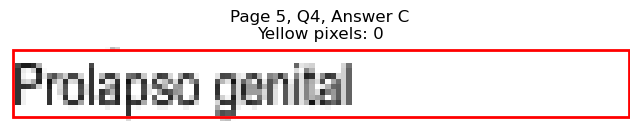

Page 5, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=387.8, y1=341.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 306
Page 5, Q4, D: Yellow percentage: 0.0%


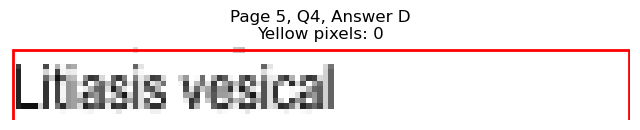


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=162.6, y1=379.8
Page 5, Q5, A: Yellow pixels: 1508
Page 5, Q5, A: Total non-white pixels: 1885
Page 5, Q5, A: Yellow percentage: 80.0%


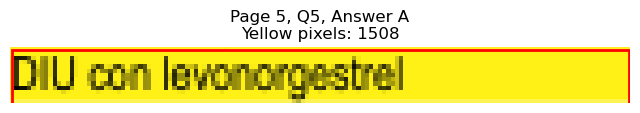

Page 5, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=123.0, y1=392.4
Page 5, Q5, B: Yellow pixels: 105
Page 5, Q5, B: Total non-white pixels: 386
Page 5, Q5, B: Yellow percentage: 27.2%


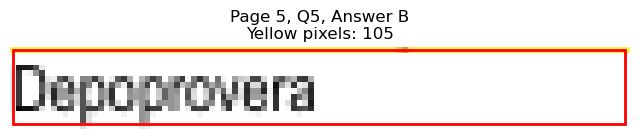

Page 5, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=402.3, y1=379.8
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 376
Page 5, Q5, C: Yellow percentage: 0.0%


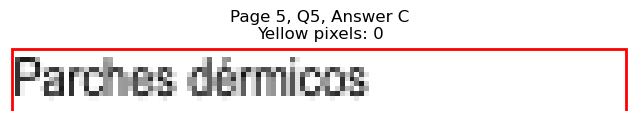

Page 5, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=405.3, y1=392.4
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 404
Page 5, Q5, D: Yellow percentage: 0.0%


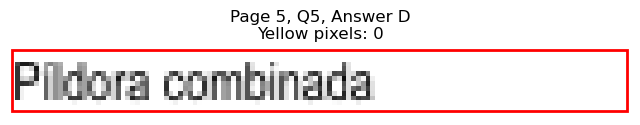


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=115.0, y1=442.9
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 231
Page 5, Q6, A: Yellow percentage: 0.0%


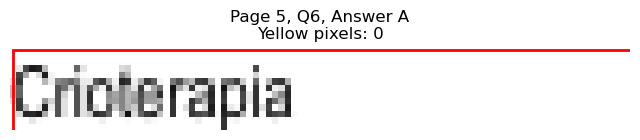

Page 5, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=165.1, y1=455.5
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 459
Page 5, Q6, B: Yellow percentage: 0.0%


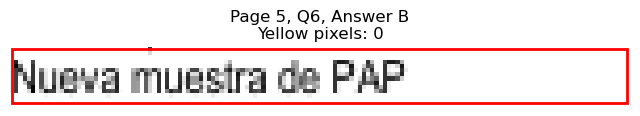

Page 5, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=390.2, y1=442.9
Page 5, Q6, C: Yellow pixels: 1236
Page 5, Q6, C: Total non-white pixels: 1482
Page 5, Q6, C: Yellow percentage: 83.4%


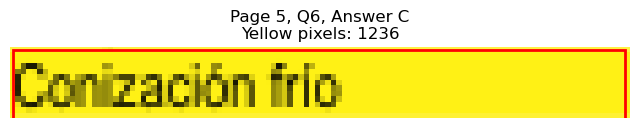

Page 5, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=385.7, y1=455.5
Page 5, Q6, D: Yellow pixels: 109
Page 5, Q6, D: Total non-white pixels: 424
Page 5, Q6, D: Yellow percentage: 25.7%


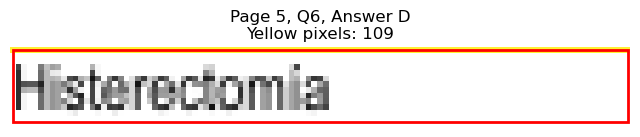


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=108.5, y1=518.6
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 191
Page 5, Q7, A: Yellow percentage: 0.0%


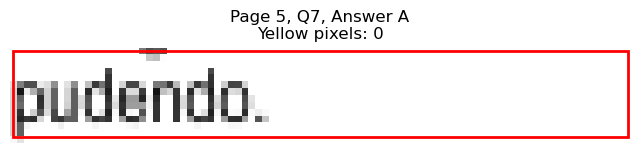

Page 5, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=110.9, y1=531.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 230
Page 5, Q7, B: Yellow percentage: 0.0%


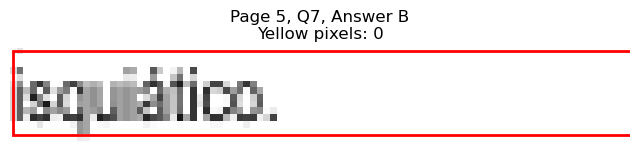

Page 5, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=392.2, y1=518.6
Page 5, Q7, C: Yellow pixels: 116
Page 5, Q7, C: Total non-white pixels: 428
Page 5, Q7, C: Yellow percentage: 27.1%


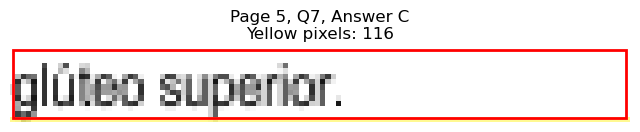

Page 5, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=371.2, y1=531.2
Page 5, Q7, D: Yellow pixels: 1068
Page 5, Q7, D: Total non-white pixels: 1330
Page 5, Q7, D: Yellow percentage: 80.3%


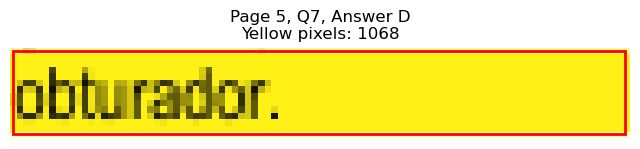


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=131.4, y1=581.8
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 313
Page 5, Q8, A: Yellow percentage: 0.0%


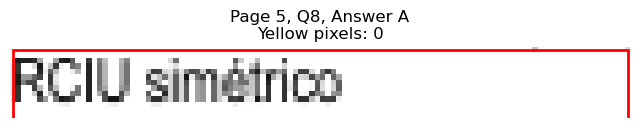

Page 5, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=136.5, y1=594.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 333
Page 5, Q8, B: Yellow percentage: 0.0%


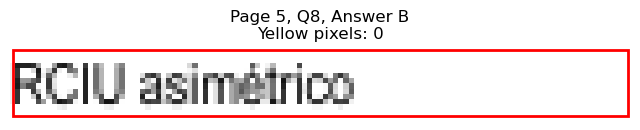

Page 5, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=383.7, y1=581.8
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 348
Page 5, Q8, C: Yellow percentage: 0.0%


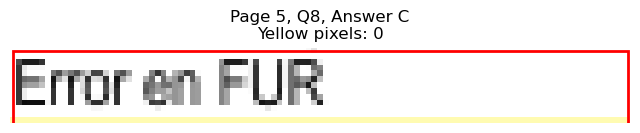

Page 5, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=469.5, y1=594.4
Page 5, Q8, D: Yellow pixels: 1751
Page 5, Q8, D: Total non-white pixels: 2702
Page 5, Q8, D: Yellow percentage: 64.8%


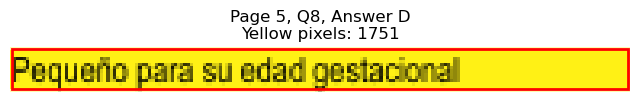


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=147.0, y1=657.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 433
Page 5, Q9, A: Yellow percentage: 0.0%


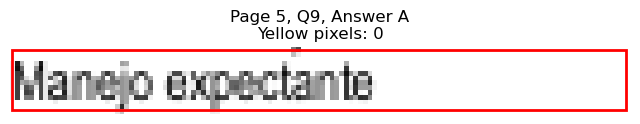

Page 5, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=173.2, y1=670.1
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 479
Page 5, Q9, B: Yellow percentage: 0.0%


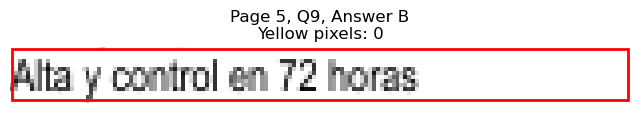

Page 5, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=426.3, y1=657.5
Page 5, Q9, C: Yellow pixels: 1578
Page 5, Q9, C: Total non-white pixels: 2100
Page 5, Q9, C: Yellow percentage: 75.1%


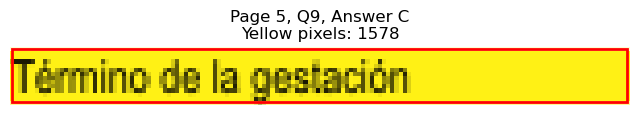

Page 5, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=389.7, y1=670.1
Page 5, Q9, D: Yellow pixels: 112
Page 5, Q9, D: Total non-white pixels: 431
Page 5, Q9, D: Yellow percentage: 26.0%


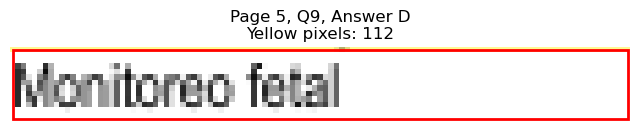


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=118.9, y1=745.8
Page 5, Q10, A: Yellow pixels: 1123
Page 5, Q10, A: Total non-white pixels: 1313
Page 5, Q10, A: Yellow percentage: 85.5%


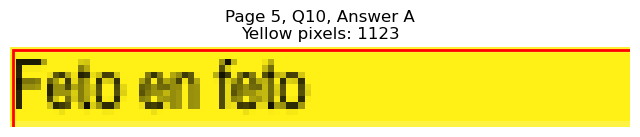

Page 5, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=141.5, y1=758.4
Page 5, Q10, B: Yellow pixels: 124
Page 5, Q10, B: Total non-white pixels: 501
Page 5, Q10, B: Yellow percentage: 24.8%


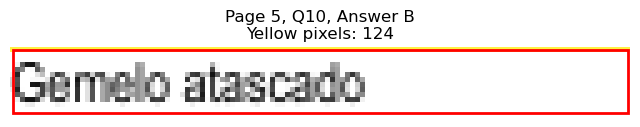

Page 5, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=428.8, y1=745.8
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 504
Page 5, Q10, C: Yellow percentage: 0.0%


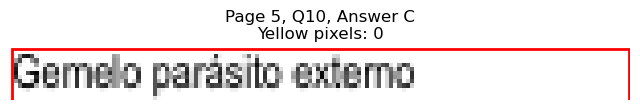

Page 5, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=412.9, y1=758.4
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 440
Page 5, Q10, D: Yellow percentage: 0.0%


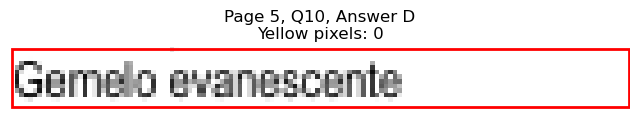


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=260.0, y1=102.1
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 969
Page 6, Q1, A: Yellow percentage: 0.0%


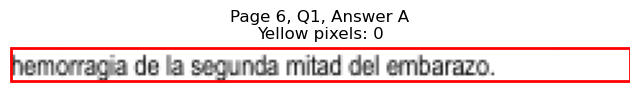

Page 6, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=139.5, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 343
Page 6, Q1, B: Yellow percentage: 0.0%


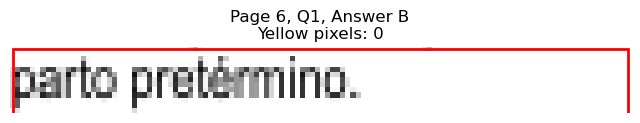

Page 6, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=442.4, y1=102.1
Page 6, Q1, C: Yellow pixels: 166
Page 6, Q1, C: Total non-white pixels: 748
Page 6, Q1, C: Yellow percentage: 22.2%


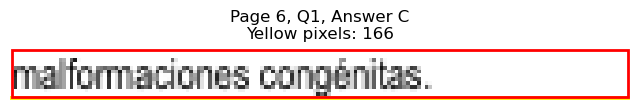

Page 6, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=445.9, y1=114.7
Page 6, Q1, D: Yellow pixels: 1763
Page 6, Q1, D: Total non-white pixels: 2197
Page 6, Q1, D: Yellow percentage: 80.2%


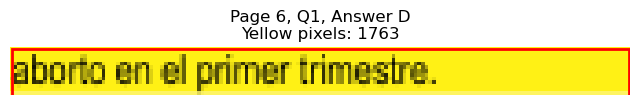


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=208.7, y1=152.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 681
Page 6, Q2, A: Yellow percentage: 0.0%


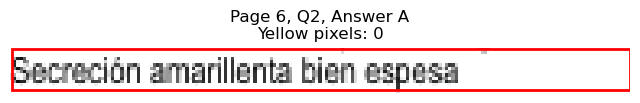

Page 6, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=280.0, y1=165.2
Page 6, Q2, B: Yellow pixels: 178
Page 6, Q2, B: Total non-white pixels: 1275
Page 6, Q2, B: Yellow percentage: 14.0%


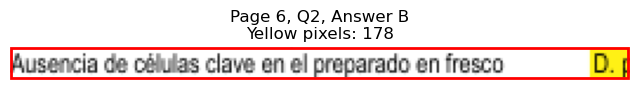

Page 6, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=439.9, y1=152.6
Page 6, Q2, C: Yellow pixels: 163
Page 6, Q2, C: Total non-white pixels: 708
Page 6, Q2, C: Yellow percentage: 23.0%


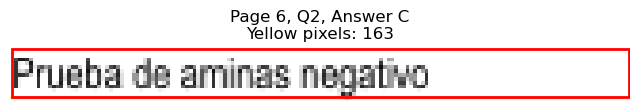

Page 6, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=427.9, y1=165.2
Page 6, Q2, D: Yellow pixels: 1590
Page 6, Q2, D: Total non-white pixels: 2114
Page 6, Q2, D: Yellow percentage: 75.2%


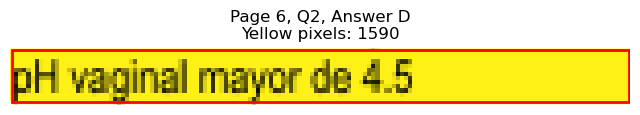


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=193.7, y1=228.3
Page 6, Q3, A: Yellow pixels: 176
Page 6, Q3, A: Total non-white pixels: 788
Page 6, Q3, A: Yellow percentage: 22.3%


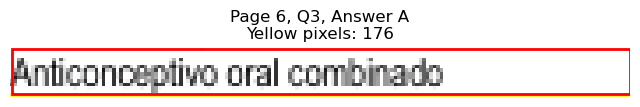

Page 6, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=115.0, y1=240.9
Page 6, Q3, B: Yellow pixels: 1075
Page 6, Q3, B: Total non-white pixels: 1261
Page 6, Q3, B: Yellow percentage: 85.2%


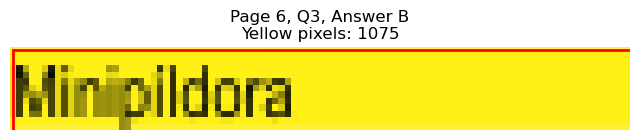

Page 6, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=436.4, y1=228.3
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 553
Page 6, Q3, C: Yellow percentage: 0.0%


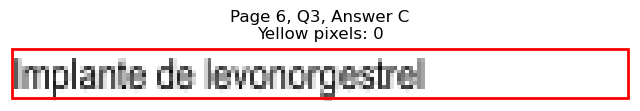

Page 6, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=400.7, y1=240.9
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 372
Page 6, Q3, D: Yellow percentage: 0.0%


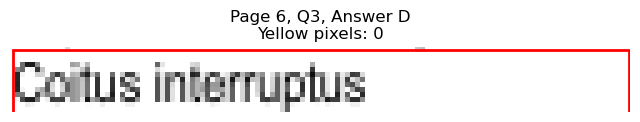


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=190.2, y1=316.7
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 642
Page 6, Q4, A: Yellow percentage: 0.0%


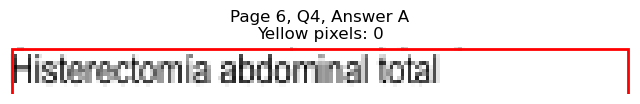

Page 6, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=147.0, y1=329.3
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 429
Page 6, Q4, B: Yellow percentage: 0.0%


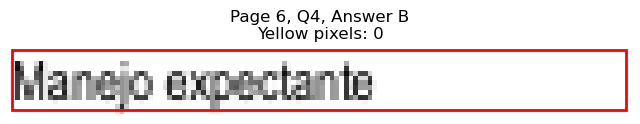

Page 6, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=491.6, y1=316.7
Page 6, Q4, C: Yellow pixels: 2148
Page 6, Q4, C: Total non-white pixels: 2782
Page 6, Q4, C: Yellow percentage: 77.2%


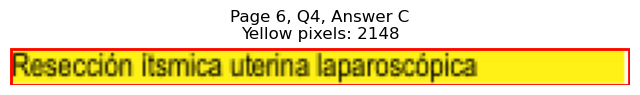

Page 6, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=428.3, y1=329.3
Page 6, Q4, D: Yellow pixels: 152
Page 6, Q4, D: Total non-white pixels: 635
Page 6, Q4, D: Yellow percentage: 23.9%


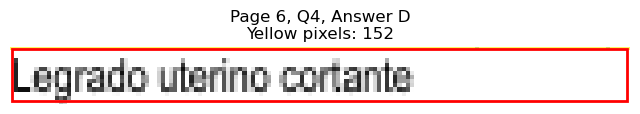


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=151.6, y1=392.4
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 427
Page 6, Q5, A: Yellow percentage: 0.0%


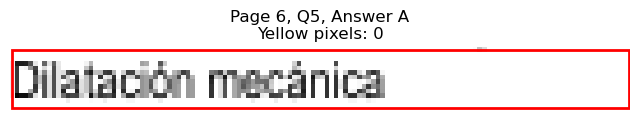

Page 6, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=160.1, y1=405.0
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 459
Page 6, Q5, B: Yellow percentage: 0.0%


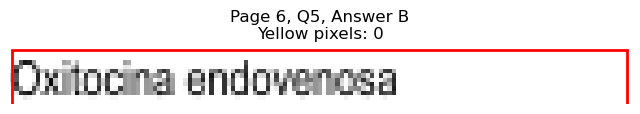

Page 6, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=390.8, y1=392.4
Page 6, Q5, C: Yellow pixels: 114
Page 6, Q5, C: Total non-white pixels: 426
Page 6, Q5, C: Yellow percentage: 26.8%


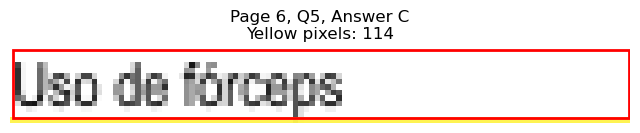

Page 6, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=426.3, y1=405.0
Page 6, Q5, D: Yellow pixels: 1550
Page 6, Q5, D: Total non-white pixels: 1950
Page 6, Q5, D: Yellow percentage: 79.5%


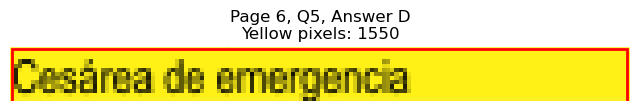


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=114.5, y1=468.1
Page 6, Q6, A: Yellow pixels: 97
Page 6, Q6, A: Total non-white pixels: 342
Page 6, Q6, A: Yellow percentage: 28.4%


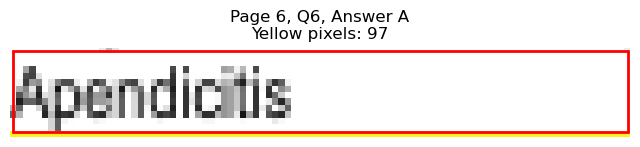

Page 6, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=170.7, y1=480.7
Page 6, Q6, B: Yellow pixels: 1600
Page 6, Q6, B: Total non-white pixels: 1989
Page 6, Q6, B: Yellow percentage: 80.4%


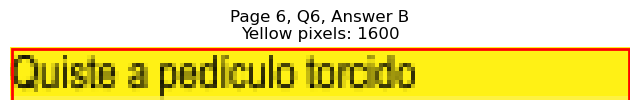

Page 6, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=378.2, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 291
Page 6, Q6, C: Yellow percentage: 0.0%


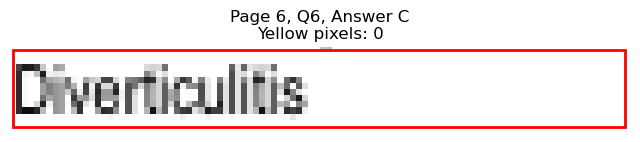

Page 6, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=458.9, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 667
Page 6, Q6, D: Yellow percentage: 0.0%


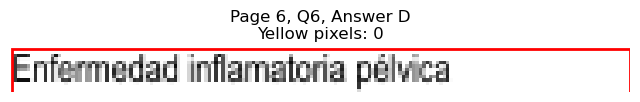


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=116.9, y1=531.2
Page 6, Q7, A: Yellow pixels: 1104
Page 6, Q7, A: Total non-white pixels: 1386
Page 6, Q7, A: Yellow percentage: 79.7%


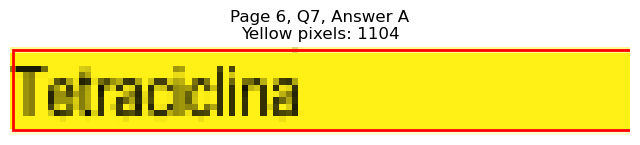

Page 6, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=135.5, y1=543.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 468
Page 6, Q7, B: Yellow percentage: 0.0%


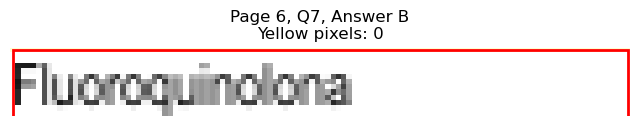

Page 6, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=393.8, y1=531.2
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 352
Page 6, Q7, C: Yellow percentage: 0.0%


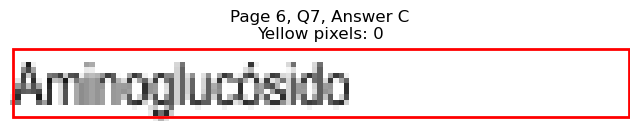

Page 6, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=385.7, y1=543.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 301
Page 6, Q7, D: Yellow percentage: 0.0%


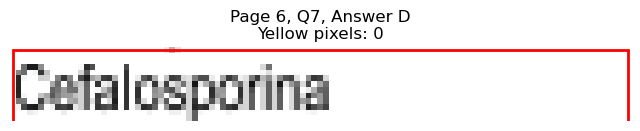


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=114.5, y1=594.4
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 202
Page 6, Q8, A: Yellow percentage: 0.0%


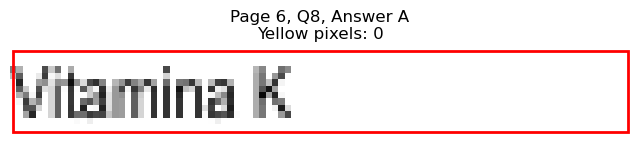

Page 6, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=100.9, y1=607.0
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 160
Page 6, Q8, B: Yellow percentage: 0.0%


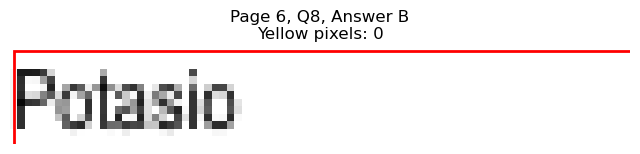

Page 6, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=374.7, y1=594.4
Page 6, Q8, C: Yellow pixels: 98
Page 6, Q8, C: Total non-white pixels: 331
Page 6, Q8, C: Yellow percentage: 29.6%


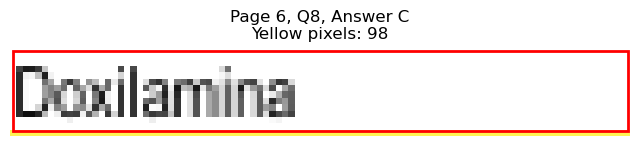

Page 6, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=362.1, y1=607.0
Page 6, Q8, D: Yellow pixels: 993
Page 6, Q8, D: Total non-white pixels: 1118
Page 6, Q8, D: Yellow percentage: 88.8%


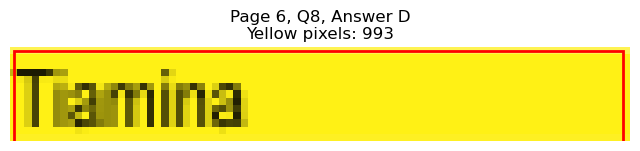


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=157.7, y1=657.5
Page 6, Q9, A: Yellow pixels: 1467
Page 6, Q9, A: Total non-white pixels: 1960
Page 6, Q9, A: Yellow percentage: 74.8%


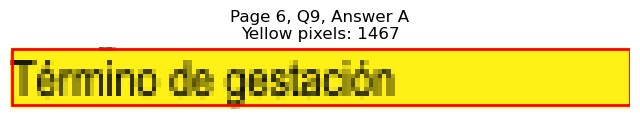

Page 6, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=227.8, y1=670.1
Page 6, Q9, B: Yellow pixels: 209
Page 6, Q9, B: Total non-white pixels: 1025
Page 6, Q9, B: Yellow percentage: 20.4%


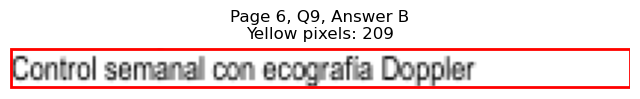

Page 6, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=404.8, y1=657.5
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 394
Page 6, Q9, C: Yellow percentage: 0.0%


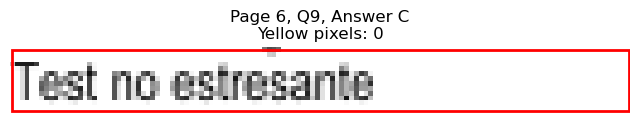

Page 6, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=480.6, y1=670.1
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 733
Page 6, Q9, D: Yellow percentage: 0.0%


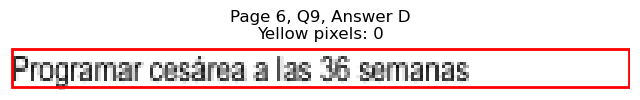


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=109.5, y1=708.0
Page 6, Q10, A: Yellow pixels: 1036
Page 6, Q10, A: Total non-white pixels: 1196
Page 6, Q10, A: Yellow percentage: 86.6%


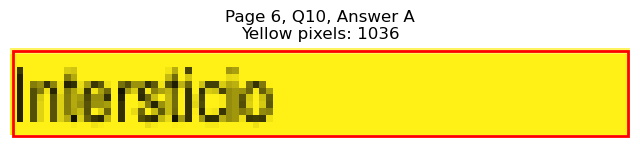

Page 6, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=100.9, y1=720.6
Page 6, Q10, B: Yellow pixels: 83
Page 6, Q10, B: Total non-white pixels: 223
Page 6, Q10, B: Yellow percentage: 37.2%


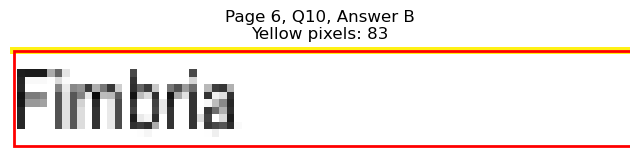

Page 6, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=352.1, y1=708.0
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 128
Page 6, Q10, C: Yellow percentage: 0.0%


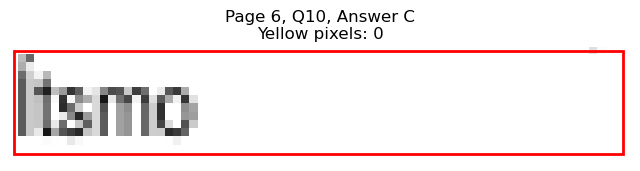

Page 6, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=362.7, y1=720.6
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 183
Page 6, Q10, D: Yellow percentage: 0.0%


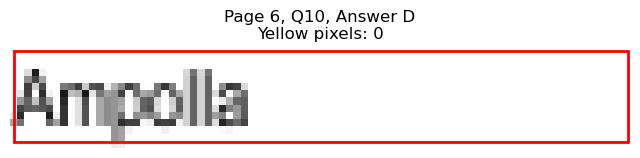


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=127.9, y1=127.3
Page 7, Q1, A: Yellow pixels: 1099
Page 7, Q1, A: Total non-white pixels: 1540
Page 7, Q1, A: Yellow percentage: 71.4%


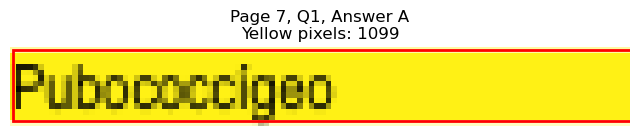

Page 7, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=141.6, y1=139.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 486
Page 7, Q1, B: Yellow percentage: 0.0%


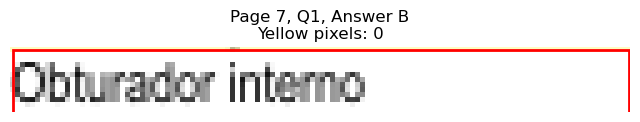

Page 7, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=395.7, y1=127.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 340
Page 7, Q1, C: Yellow percentage: 0.0%


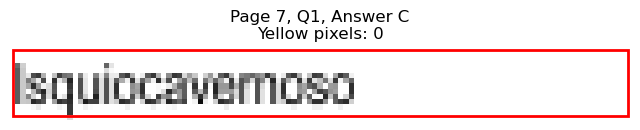

Page 7, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=413.3, y1=139.9
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 418
Page 7, Q1, D: Yellow percentage: 0.0%


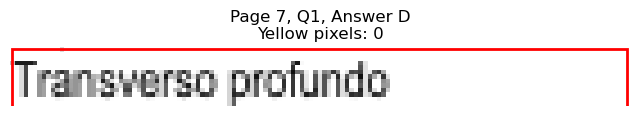


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=86.9, y1=215.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 67
Page 7, Q2, A: Yellow percentage: 0.0%


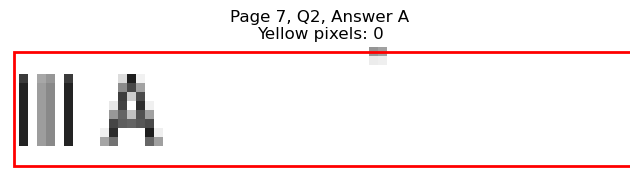

Page 7, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=84.4, y1=228.3
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 62
Page 7, Q2, B: Yellow percentage: 0.0%


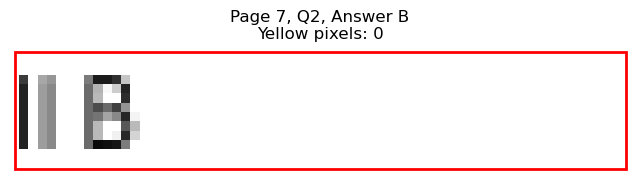

Page 7, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=346.1, y1=215.6
Page 7, Q2, C: Yellow pixels: 841
Page 7, Q2, C: Total non-white pixels: 980
Page 7, Q2, C: Yellow percentage: 85.8%


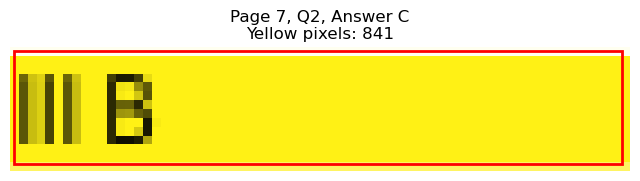

Page 7, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=343.6, y1=228.3
Page 7, Q2, D: Yellow pixels: 67
Page 7, Q2, D: Total non-white pixels: 129
Page 7, Q2, D: Yellow percentage: 51.9%


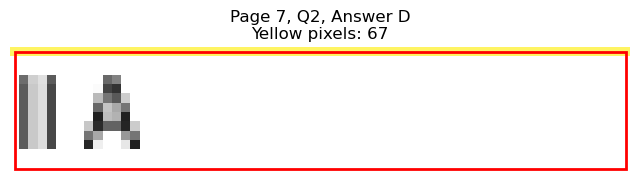


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=98.4, y1=291.5
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 131
Page 7, Q3, A: Yellow percentage: 0.0%


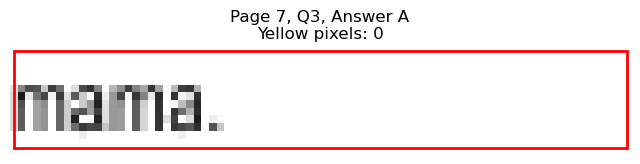

Page 7, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=96.9, y1=304.1
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 119
Page 7, Q3, B: Yellow percentage: 0.0%


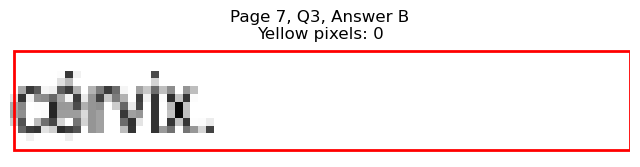

Page 7, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=357.2, y1=291.5
Page 7, Q3, C: Yellow pixels: 949
Page 7, Q3, C: Total non-white pixels: 1134
Page 7, Q3, C: Yellow percentage: 83.7%


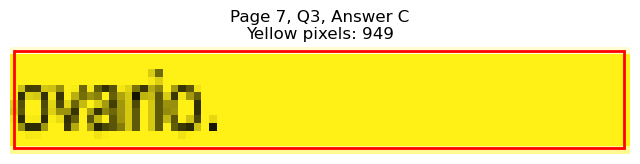

Page 7, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=370.1, y1=304.1
Page 7, Q3, D: Yellow pixels: 94
Page 7, Q3, D: Total non-white pixels: 289
Page 7, Q3, D: Yellow percentage: 32.5%


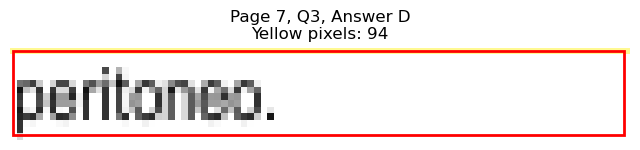


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=168.6, y1=354.6
Page 7, Q4, A: Yellow pixels: 151
Page 7, Q4, A: Total non-white pixels: 678
Page 7, Q4, A: Yellow percentage: 22.3%


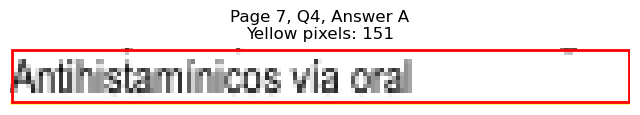

Page 7, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=142.6, y1=367.2
Page 7, Q4, B: Yellow pixels: 1328
Page 7, Q4, B: Total non-white pixels: 1750
Page 7, Q4, B: Yellow percentage: 75.9%


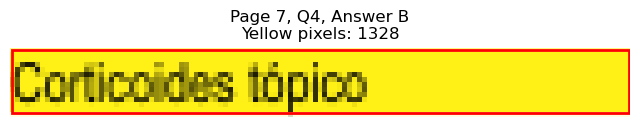

Page 7, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=381.7, y1=354.6
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 283
Page 7, Q4, C: Yellow percentage: 0.0%


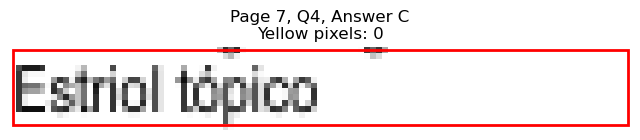

Page 7, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=404.8, y1=367.2
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 370
Page 7, Q4, D: Yellow percentage: 0.0%


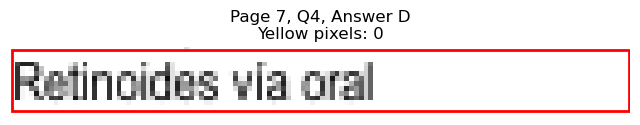


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=152.1, y1=417.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 431
Page 7, Q5, A: Yellow percentage: 0.0%


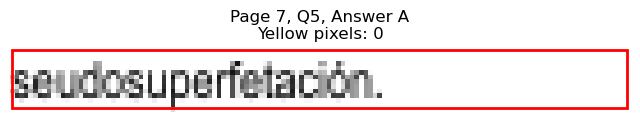

Page 7, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=127.5, y1=430.3
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 302
Page 7, Q5, B: Yellow percentage: 0.0%


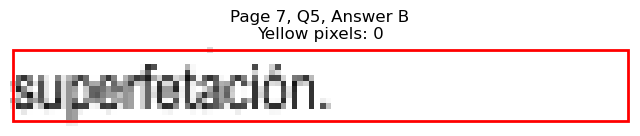

Page 7, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=403.7, y1=417.6
Page 7, Q5, C: Yellow pixels: 1346
Page 7, Q5, C: Total non-white pixels: 1778
Page 7, Q5, C: Yellow percentage: 75.7%


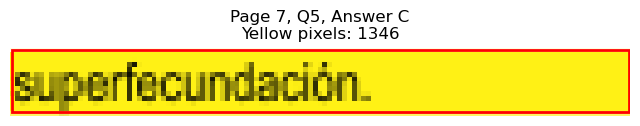

Page 7, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=399.8, y1=430.3
Page 7, Q5, D: Yellow pixels: 123
Page 7, Q5, D: Total non-white pixels: 463
Page 7, Q5, D: Yellow percentage: 26.6%


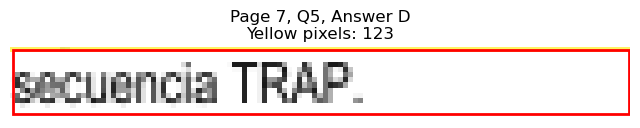


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=103.9, y1=480.7
Page 7, Q6, A: Yellow pixels: 987
Page 7, Q6, A: Total non-white pixels: 1118
Page 7, Q6, A: Yellow percentage: 88.3%


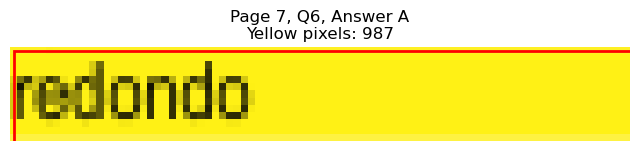

Page 7, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=137.5, y1=493.4
Page 7, Q6, B: Yellow pixels: 120
Page 7, Q6, B: Total non-white pixels: 460
Page 7, Q6, B: Yellow percentage: 26.1%


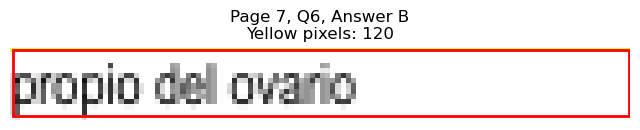

Page 7, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=401.8, y1=480.7
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 396
Page 7, Q6, C: Yellow percentage: 0.0%


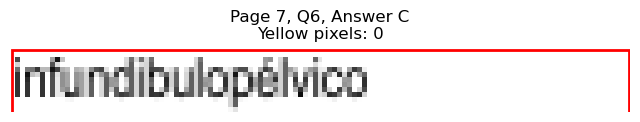

Page 7, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=361.6, y1=493.4
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 185
Page 7, Q6, D: Yellow percentage: 0.0%


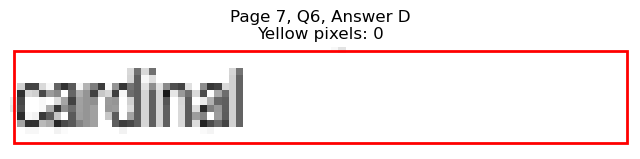


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=120.5, y1=556.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 270
Page 7, Q7, A: Yellow percentage: 0.0%


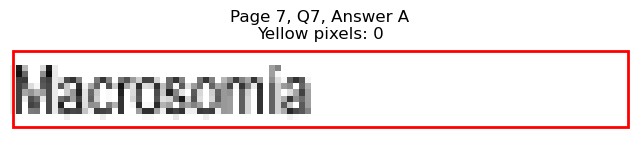

Page 7, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=162.1, y1=569.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 460
Page 7, Q7, B: Yellow percentage: 0.0%


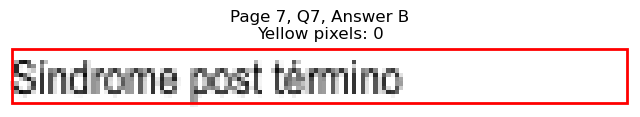

Page 7, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=382.3, y1=556.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 292
Page 7, Q7, C: Yellow percentage: 0.0%


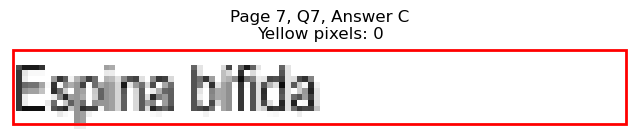

Page 7, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=360.7, y1=569.2
Page 7, Q7, D: Yellow pixels: 971
Page 7, Q7, D: Total non-white pixels: 1176
Page 7, Q7, D: Yellow percentage: 82.6%


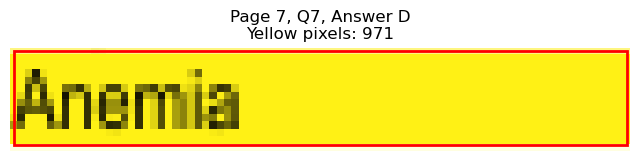


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=123.5, y1=607.0
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 272
Page 7, Q8, A: Yellow percentage: 0.0%


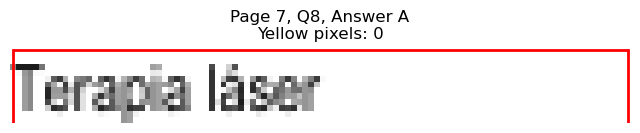

Page 7, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=163.1, y1=619.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 454
Page 7, Q8, B: Yellow percentage: 0.0%


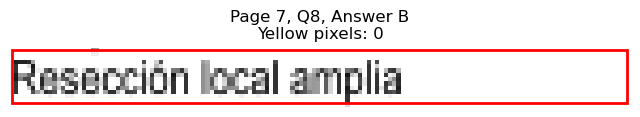

Page 7, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=380.7, y1=607.0
Page 7, Q8, C: Yellow pixels: 1150
Page 7, Q8, C: Total non-white pixels: 1352
Page 7, Q8, C: Yellow percentage: 85.1%


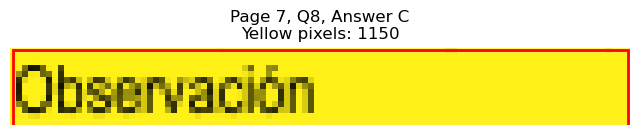

Page 7, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=466.5, y1=619.6
Page 7, Q8, D: Yellow pixels: 190
Page 7, Q8, D: Total non-white pixels: 865
Page 7, Q8, D: Yellow percentage: 22.0%


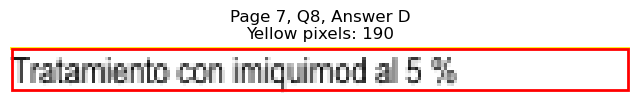


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=153.0, y1=682.7
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 371
Page 7, Q9, A: Yellow percentage: 0.0%


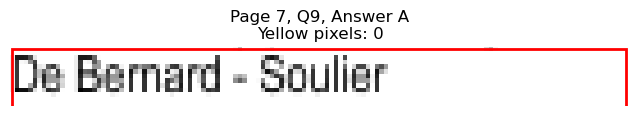

Page 7, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=115.9, y1=695.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 242
Page 7, Q9, B: Yellow percentage: 0.0%


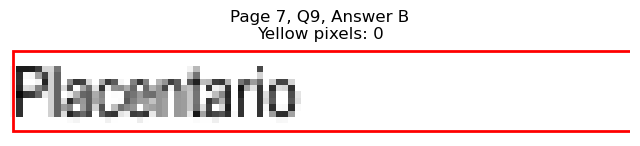

Page 7, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=401.7, y1=682.7
Page 7, Q9, C: Yellow pixels: 2
Page 7, Q9, C: Total non-white pixels: 473
Page 7, Q9, C: Yellow percentage: 0.4%


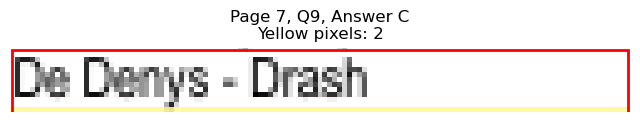

Page 7, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=372.7, y1=695.3
Page 7, Q9, D: Yellow pixels: 966
Page 7, Q9, D: Total non-white pixels: 1344
Page 7, Q9, D: Yellow percentage: 71.9%


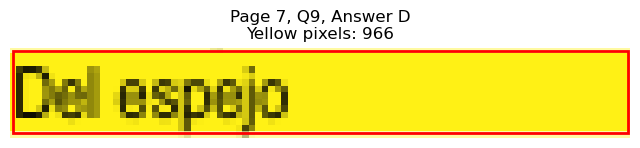


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=225.3, y1=758.4
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 794
Page 7, Q10, A: Yellow percentage: 0.0%


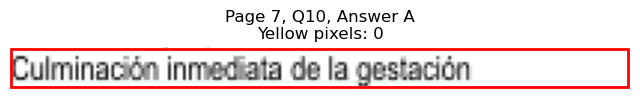

Page 7, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=274.0, y1=771.2
Page 7, Q10, B: Yellow pixels: 11
Page 7, Q10, B: Total non-white pixels: 1061
Page 7, Q10, B: Yellow percentage: 1.0%


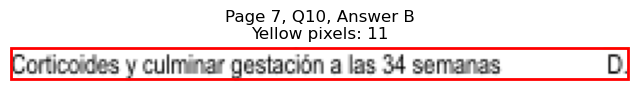

Page 7, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=462.1, y1=758.4
Page 7, Q10, C: Yellow pixels: 1899
Page 7, Q10, C: Total non-white pixels: 2604
Page 7, Q10, C: Yellow percentage: 72.9%


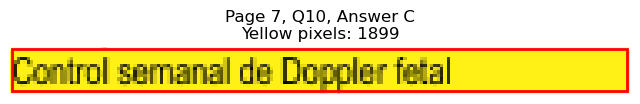

Page 7, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=473.5, y1=771.2
Page 7, Q10, D: Yellow pixels: 197
Page 7, Q10, D: Total non-white pixels: 899
Page 7, Q10, D: Yellow percentage: 21.9%


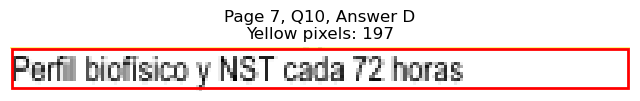


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=127.0, y1=139.9
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 295
Page 8, Q1, A: Yellow percentage: 0.0%


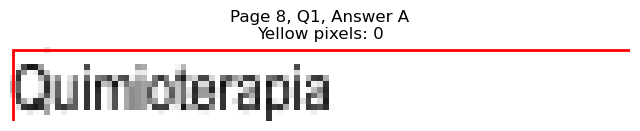

Page 8, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=176.7, y1=152.6
Page 8, Q1, B: Yellow pixels: 1669
Page 8, Q1, B: Total non-white pixels: 2226
Page 8, Q1, B: Yellow percentage: 75.0%


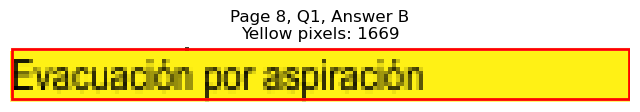

Page 8, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=423.9, y1=139.9
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 471
Page 8, Q1, C: Yellow percentage: 0.0%


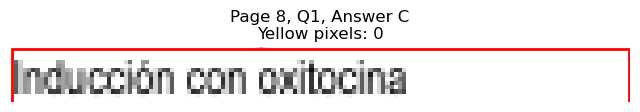

Page 8, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=426.8, y1=152.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 482
Page 8, Q1, D: Yellow percentage: 0.0%


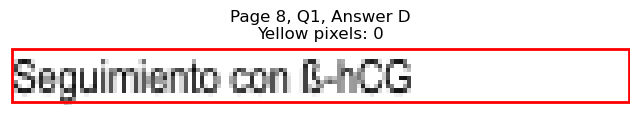


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=186.1, y1=215.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 592
Page 8, Q2, A: Yellow percentage: 0.0%


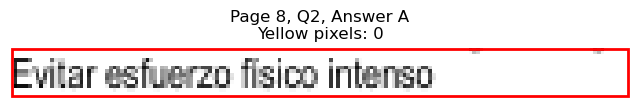

Page 8, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=147.5, y1=228.3
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 425
Page 8, Q2, B: Yellow percentage: 0.0%


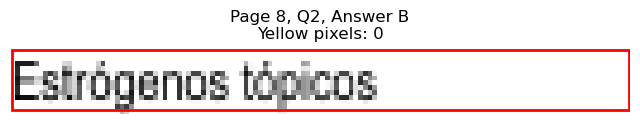

Page 8, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=411.9, y1=215.6
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 441
Page 8, Q2, C: Yellow percentage: 0.0%


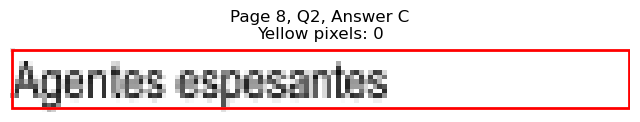

Page 8, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=429.4, y1=228.3
Page 8, Q2, D: Yellow pixels: 1451
Page 8, Q2, D: Total non-white pixels: 2142
Page 8, Q2, D: Yellow percentage: 67.7%


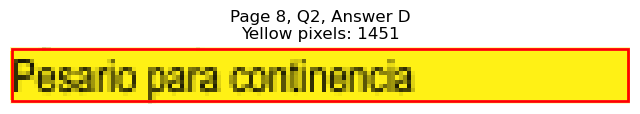


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=204.8, y1=278.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 722
Page 8, Q3, A: Yellow percentage: 0.0%


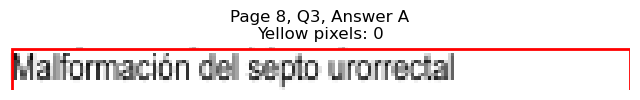

Page 8, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=174.1, y1=291.5
Page 8, Q3, B: Yellow pixels: 1644
Page 8, Q3, B: Total non-white pixels: 2198
Page 8, Q3, B: Yellow percentage: 74.8%


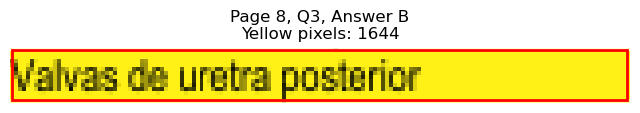

Page 8, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=373.3, y1=278.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 233
Page 8, Q3, C: Yellow percentage: 0.0%


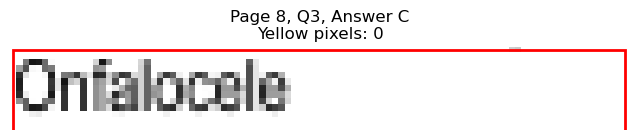

Page 8, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=417.8, y1=291.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 467
Page 8, Q3, D: Yellow percentage: 0.0%


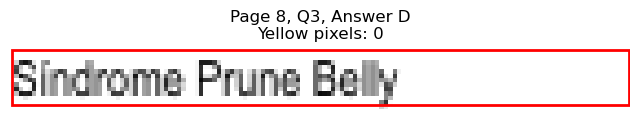


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=140.1, y1=341.9
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 376
Page 8, Q4, A: Yellow percentage: 0.0%


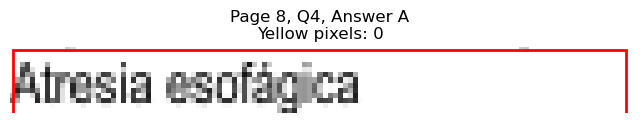

Page 8, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=138.5, y1=354.6
Page 8, Q4, B: Yellow pixels: 1273
Page 8, Q4, B: Total non-white pixels: 1694
Page 8, Q4, B: Yellow percentage: 75.1%


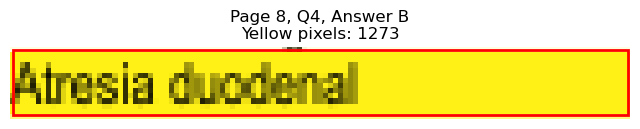

Page 8, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=373.3, y1=278.7
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 233
Page 8, Q4, C: Yellow percentage: 0.0%


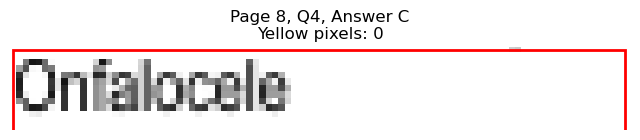

Page 8, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=458.9, y1=354.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 680
Page 8, Q4, D: Yellow percentage: 0.0%


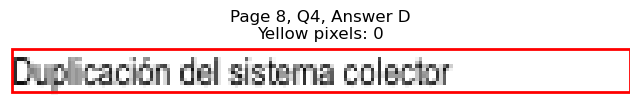


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=138.5, y1=392.4
Page 8, Q5, A: Yellow pixels: 121
Page 8, Q5, A: Total non-white pixels: 465
Page 8, Q5, A: Yellow percentage: 26.0%


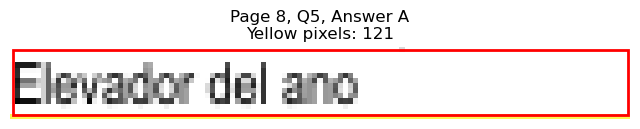

Page 8, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=135.5, y1=405.0
Page 8, Q5, B: Yellow pixels: 1273
Page 8, Q5, B: Total non-white pixels: 1534
Page 8, Q5, B: Yellow percentage: 83.0%


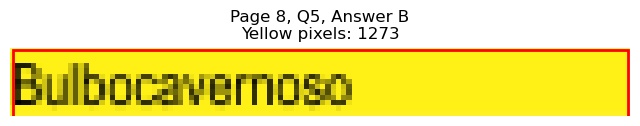

Page 8, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=400.7, y1=392.4
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 370
Page 8, Q5, C: Yellow percentage: 0.0%


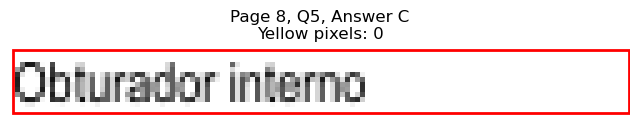

Page 8, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=389.7, y1=405.0
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 315
Page 8, Q5, D: Yellow percentage: 0.0%


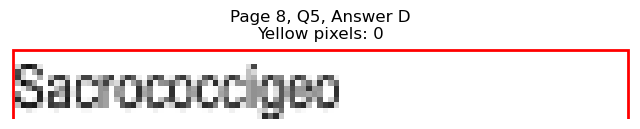


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=112.0, y1=468.1
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 233
Page 8, Q6, A: Yellow percentage: 0.0%


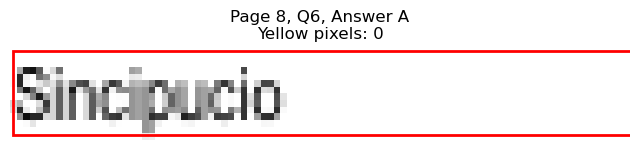

Page 8, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=96.9, y1=480.7
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 138
Page 8, Q6, B: Yellow percentage: 0.0%


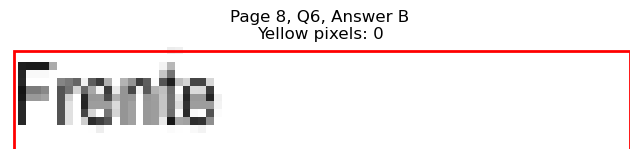

Page 8, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=349.6, y1=468.1
Page 8, Q6, C: Yellow pixels: 73
Page 8, Q6, C: Total non-white pixels: 179
Page 8, Q6, C: Yellow percentage: 40.8%


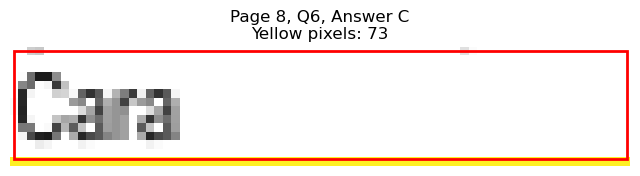

Page 8, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=369.7, y1=480.7
Page 8, Q6, D: Yellow pixels: 1064
Page 8, Q6, D: Total non-white pixels: 1209
Page 8, Q6, D: Yellow percentage: 88.0%


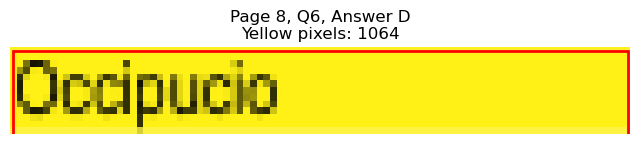


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=142.0, y1=531.2
Page 8, Q7, A: Yellow pixels: 1281
Page 8, Q7, A: Total non-white pixels: 1736
Page 8, Q7, A: Yellow percentage: 73.8%


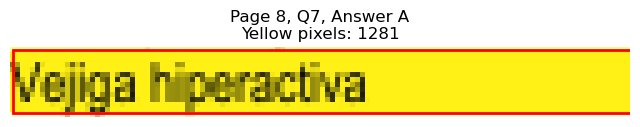

Page 8, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=171.1, y1=543.8
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 659
Page 8, Q7, B: Yellow percentage: 0.0%


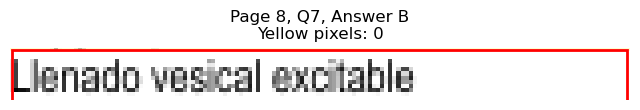

Page 8, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=437.3, y1=531.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 586
Page 8, Q7, C: Yellow percentage: 0.0%


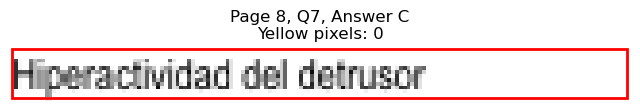

Page 8, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=439.9, y1=543.8
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 578
Page 8, Q7, D: Yellow percentage: 0.0%


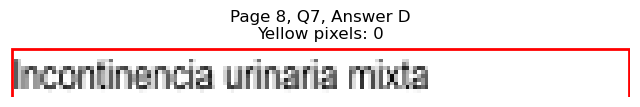


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=178.7, y1=594.4
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 525
Page 8, Q8, A: Yellow percentage: 0.0%


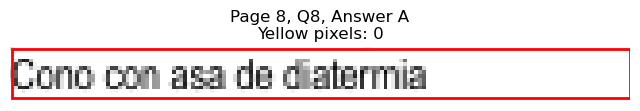

Page 8, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=184.7, y1=607.0
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 595
Page 8, Q8, B: Yellow percentage: 0.0%


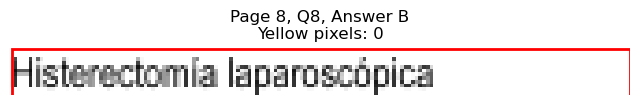

Page 8, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=460.0, y1=594.4
Page 8, Q8, C: Yellow pixels: 1714
Page 8, Q8, C: Total non-white pixels: 2576
Page 8, Q8, C: Yellow percentage: 66.5%


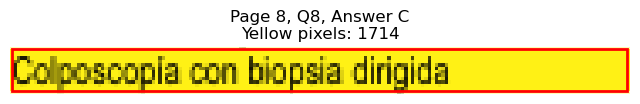

Page 8, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=428.8, y1=607.0
Page 8, Q8, D: Yellow pixels: 1
Page 8, Q8, D: Total non-white pixels: 643
Page 8, Q8, D: Yellow percentage: 0.2%


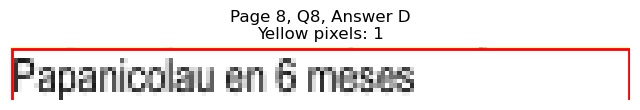


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=132.0, y1=670.1
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 278
Page 8, Q9, A: Yellow percentage: 0.0%


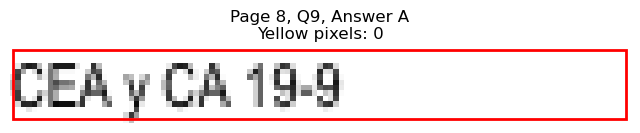

Page 8, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=143.5, y1=682.7
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 325
Page 8, Q9, B: Yellow percentage: 0.0%


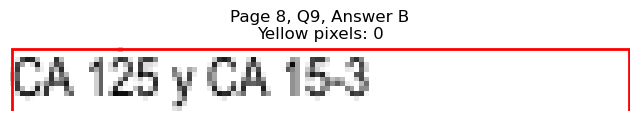

Page 8, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=375.7, y1=670.1
Page 8, Q9, C: Yellow pixels: 1126
Page 8, Q9, C: Total non-white pixels: 1386
Page 8, Q9, C: Yellow percentage: 81.2%


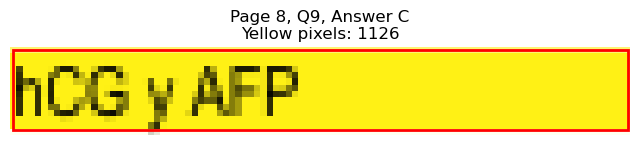

Page 8, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=387.7, y1=682.7
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 364
Page 8, Q9, D: Yellow percentage: 0.0%


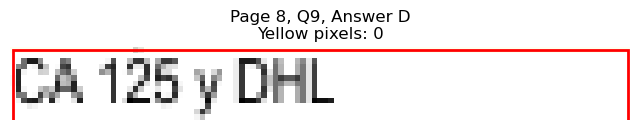


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=157.6, y1=745.8
Page 8, Q10, A: Yellow pixels: 1468
Page 8, Q10, A: Total non-white pixels: 1820
Page 8, Q10, A: Yellow percentage: 80.7%


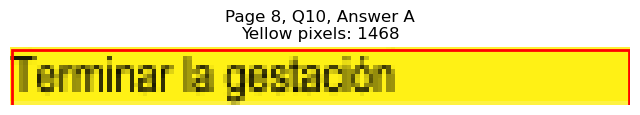

Page 8, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=178.1, y1=758.4
Page 8, Q10, B: Yellow pixels: 159
Page 8, Q10, B: Total non-white pixels: 684
Page 8, Q10, B: Yellow percentage: 23.2%


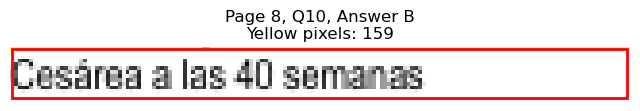

Page 8, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=473.5, y1=745.8
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 699
Page 8, Q10, C: Yellow percentage: 0.0%


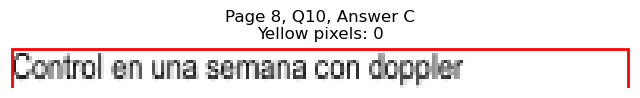

Page 8, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=454.5, y1=758.4
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 635
Page 8, Q10, D: Yellow percentage: 0.0%


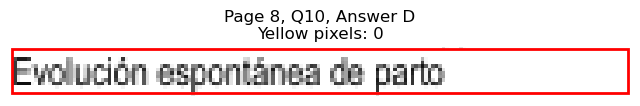


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=126.5, y1=127.3
Page 9, Q1, A: Yellow pixels: 109
Page 9, Q1, A: Total non-white pixels: 421
Page 9, Q1, A: Yellow percentage: 25.9%


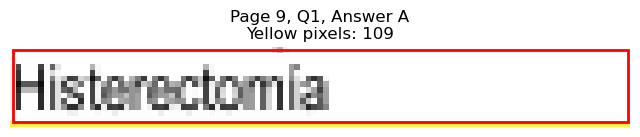

Page 9, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=121.5, y1=139.9
Page 9, Q1, B: Yellow pixels: 1133
Page 9, Q1, B: Total non-white pixels: 1352
Page 9, Q1, B: Yellow percentage: 83.8%


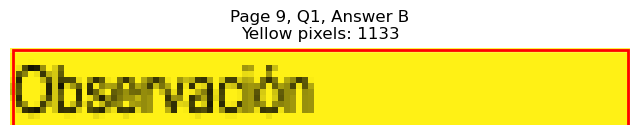

Page 9, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=380.7, y1=127.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 257
Page 9, Q1, C: Yellow percentage: 0.0%


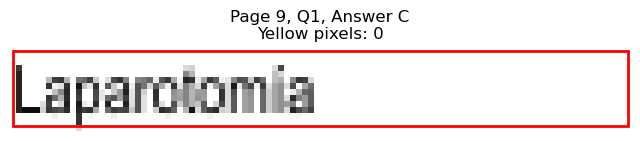

Page 9, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=384.8, y1=139.9
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 274
Page 9, Q1, D: Yellow percentage: 0.0%


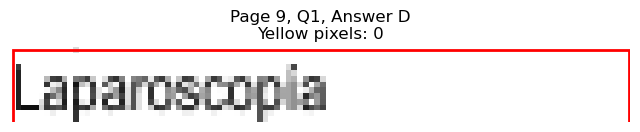


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=141.5, y1=203.0
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 363
Page 9, Q2, A: Yellow percentage: 0.0%


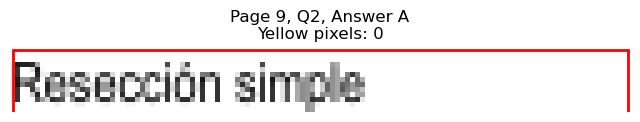

Page 9, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=143.5, y1=215.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 407
Page 9, Q2, B: Yellow percentage: 0.0%


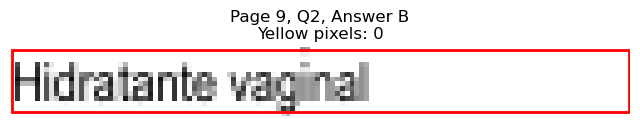

Page 9, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=391.3, y1=203.0
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 461
Page 9, Q2, C: Yellow percentage: 0.0%


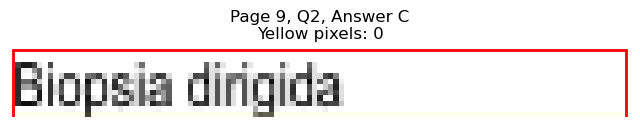

Page 9, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=406.7, y1=215.6
Page 9, Q2, D: Yellow pixels: 1374
Page 9, Q2, D: Total non-white pixels: 1820
Page 9, Q2, D: Yellow percentage: 75.5%


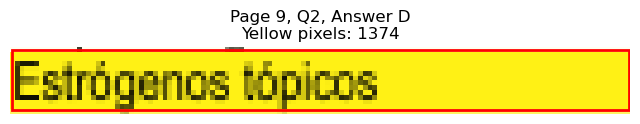


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=137.5, y1=278.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 346
Page 9, Q3, A: Yellow percentage: 0.0%


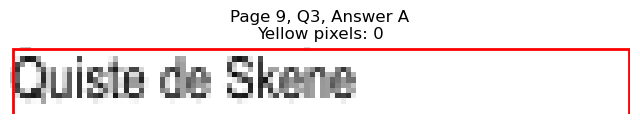

Page 9, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=132.5, y1=291.5
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 314
Page 9, Q3, B: Yellow percentage: 0.0%


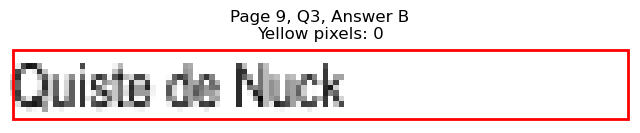

Page 9, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=374.7, y1=278.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 231
Page 9, Q3, C: Yellow percentage: 0.0%


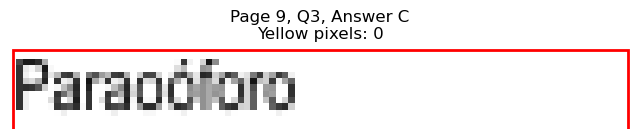

Page 9, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=401.8, y1=291.5
Page 9, Q3, D: Yellow pixels: 1346
Page 9, Q3, D: Total non-white pixels: 1750
Page 9, Q3, D: Yellow percentage: 76.9%


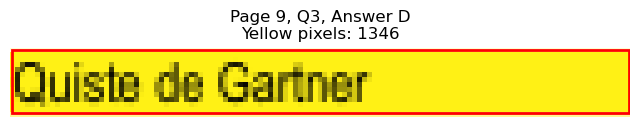


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=130.9, y1=341.9
Page 9, Q4, A: Yellow pixels: 1209
Page 9, Q4, A: Total non-white pixels: 1469
Page 9, Q4, A: Yellow percentage: 82.3%


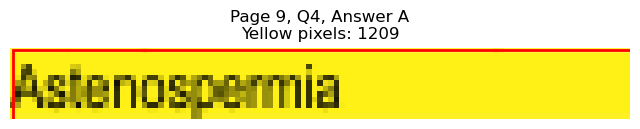

Page 9, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=124.0, y1=354.6
Page 9, Q4, B: Yellow pixels: 104
Page 9, Q4, B: Total non-white pixels: 397
Page 9, Q4, B: Yellow percentage: 26.2%


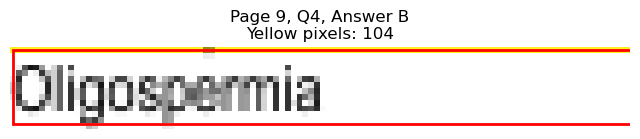

Page 9, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=388.3, y1=341.9
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 308
Page 9, Q4, C: Yellow percentage: 0.0%


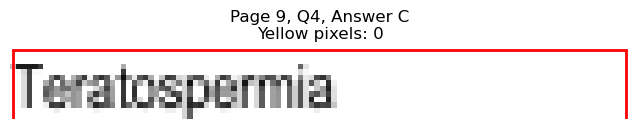

Page 9, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=410.3, y1=354.6
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 436
Page 9, Q4, D: Yellow percentage: 0.0%


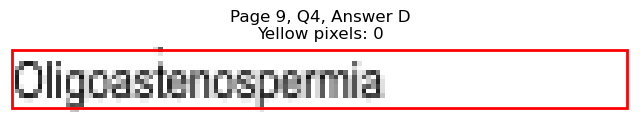


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=200.2, y1=417.6
Page 9, Q5, A: Yellow pixels: 1870
Page 9, Q5, A: Total non-white pixels: 2562
Page 9, Q5, A: Yellow percentage: 73.0%


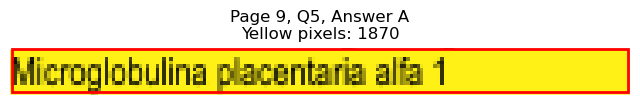

Page 9, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=241.4, y1=430.3
Page 9, Q5, B: Yellow pixels: 211
Page 9, Q5, B: Total non-white pixels: 1073
Page 9, Q5, B: Yellow percentage: 19.7%


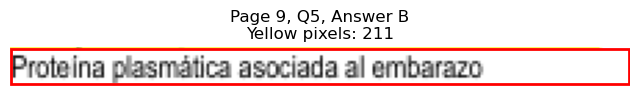

Page 9, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=463.5, y1=417.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 703
Page 9, Q5, C: Yellow percentage: 0.0%


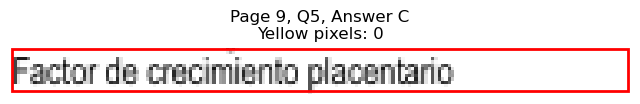

Page 9, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=424.9, y1=430.3
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 474
Page 9, Q5, D: Yellow percentage: 0.0%


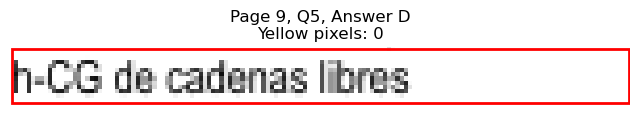


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=234.9, y1=468.1
Page 9, Q6, A: Yellow pixels: 213
Page 9, Q6, A: Total non-white pixels: 1041
Page 9, Q6, A: Yellow percentage: 20.5%


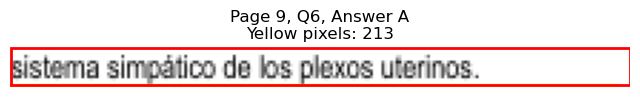

Page 9, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=250.8, y1=480.7
Page 9, Q6, B: Yellow pixels: 2040
Page 9, Q6, B: Total non-white pixels: 2782
Page 9, Q6, B: Yellow percentage: 73.3%


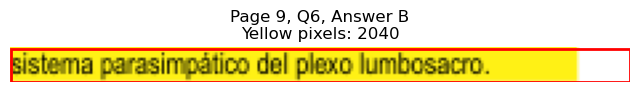

Page 9, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=394.7, y1=468.1
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 312
Page 9, Q6, C: Yellow percentage: 0.0%


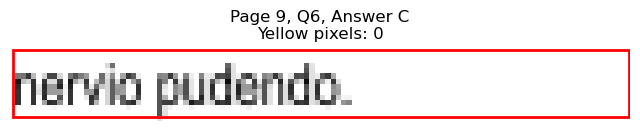

Page 9, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=405.3, y1=480.7
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 390
Page 9, Q6, D: Yellow percentage: 0.0%


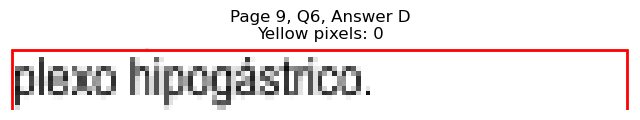


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=118.0, y1=531.2
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 237
Page 9, Q7, A: Yellow percentage: 0.0%


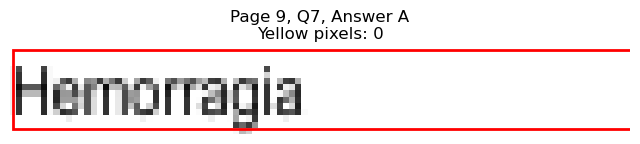

Page 9, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=147.0, y1=543.8
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 373
Page 9, Q7, B: Yellow percentage: 0.0%


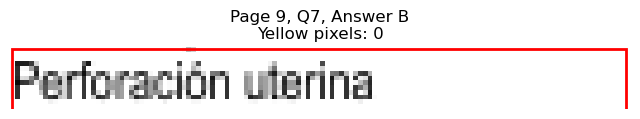

Page 9, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=380.2, y1=531.2
Page 9, Q7, C: Yellow pixels: 104
Page 9, Q7, C: Total non-white pixels: 369
Page 9, Q7, C: Yellow percentage: 28.2%


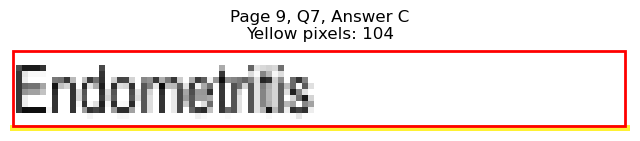

Page 9, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=406.3, y1=543.8
Page 9, Q7, D: Yellow pixels: 1379
Page 9, Q7, D: Total non-white pixels: 1690
Page 9, Q7, D: Yellow percentage: 81.6%


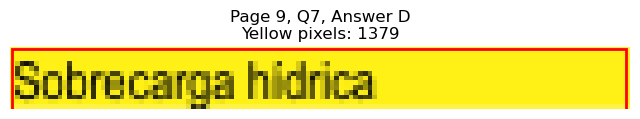


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=65.2, y1=619.6
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 46
Page 9, Q8, A: Yellow percentage: 0.0%


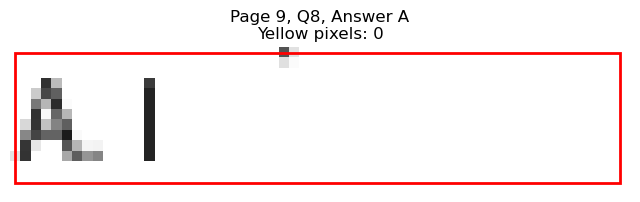

Page 9, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=65.2, y1=632.3
Page 9, Q8, B: Yellow pixels: 659
Page 9, Q8, B: Total non-white pixels: 840
Page 9, Q8, B: Yellow percentage: 78.5%


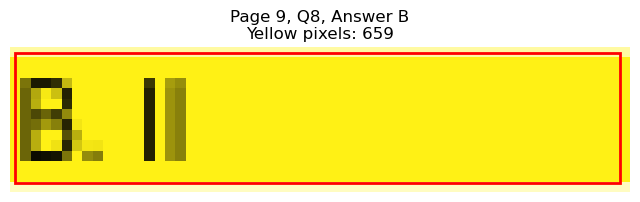

Page 9, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=337.6, y1=619.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 48
Page 9, Q8, C: Yellow percentage: 0.0%


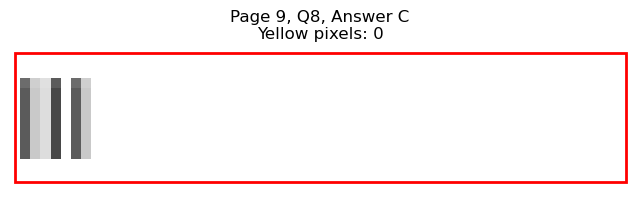

Page 9, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=338.6, y1=632.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 42
Page 9, Q8, D: Yellow percentage: 0.0%


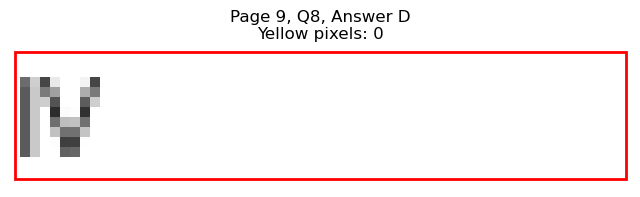


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=187.7, y1=670.1
Page 9, Q9, A: Yellow pixels: 1710
Page 9, Q9, A: Total non-white pixels: 2380
Page 9, Q9, A: Yellow percentage: 71.8%


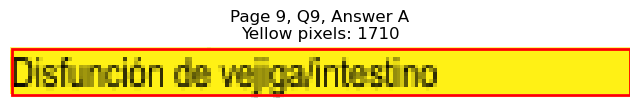

Page 9, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=209.8, y1=682.7
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 946
Page 9, Q9, B: Yellow percentage: 0.0%


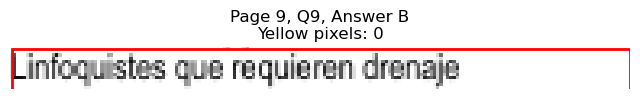

Page 9, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=413.8, y1=670.1
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 453
Page 9, Q9, C: Yellow percentage: 0.0%


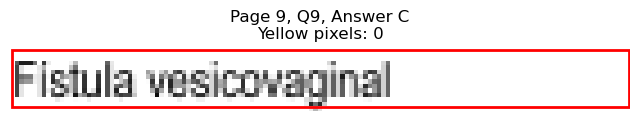

Page 9, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=441.9, y1=682.7
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 563
Page 9, Q9, D: Yellow percentage: 0.0%


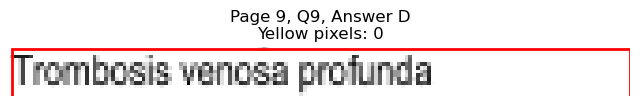


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=144.5, y1=745.8
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 402
Page 9, Q10, A: Yellow percentage: 0.0%


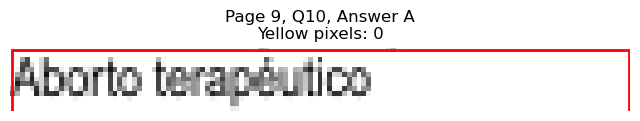

Page 9, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=146.1, y1=758.4
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 397
Page 9, Q10, B: Yellow percentage: 0.0%


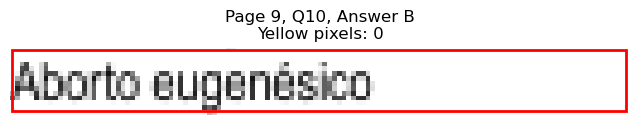

Page 9, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=471.0, y1=745.8
Page 9, Q10, C: Yellow pixels: 1
Page 9, Q10, C: Total non-white pixels: 953
Page 9, Q10, C: Yellow percentage: 0.1%


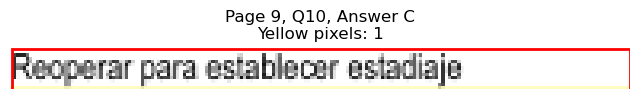

Page 9, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=427.4, y1=758.4
Page 9, Q10, D: Yellow pixels: 1592
Page 9, Q10, D: Total non-white pixels: 2114
Page 9, Q10, D: Yellow percentage: 75.3%


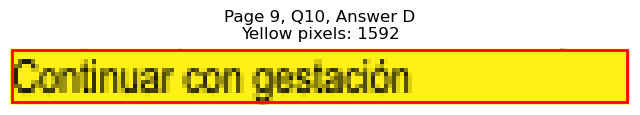


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=143.1, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 370
Page 10, Q1, A: Yellow percentage: 0.0%


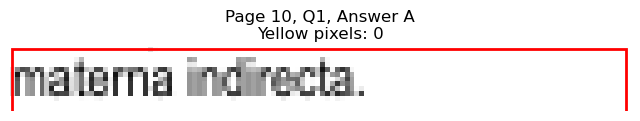

Page 10, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=124.9, y1=127.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 272
Page 10, Q1, B: Yellow percentage: 0.0%


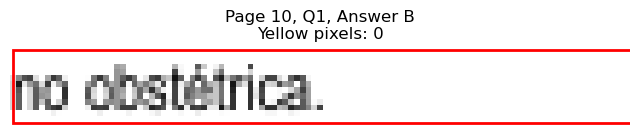

Page 10, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=448.4, y1=114.7
Page 10, Q1, C: Yellow pixels: 1795
Page 10, Q1, C: Total non-white pixels: 2236
Page 10, Q1, C: Yellow percentage: 80.3%


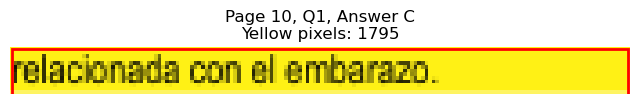

Page 10, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=395.2, y1=127.3
Page 10, Q1, D: Yellow pixels: 119
Page 10, Q1, D: Total non-white pixels: 456
Page 10, Q1, D: Yellow percentage: 26.1%


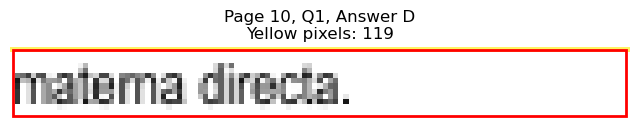


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=65.2, y1=177.8
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 43
Page 10, Q2, A: Yellow percentage: 0.0%


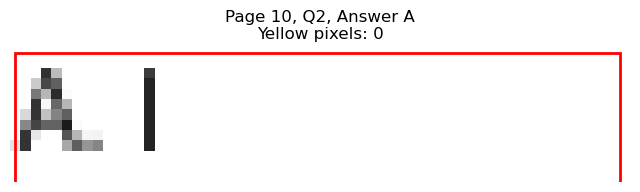

Page 10, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=78.4, y1=190.4
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 32
Page 10, Q2, B: Yellow percentage: 0.0%


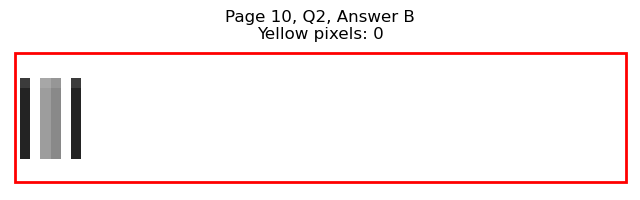

Page 10, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 10, Q2, C: Yellow pixels: 730
Page 10, Q2, C: Total non-white pixels: 780
Page 10, Q2, C: Yellow percentage: 93.6%


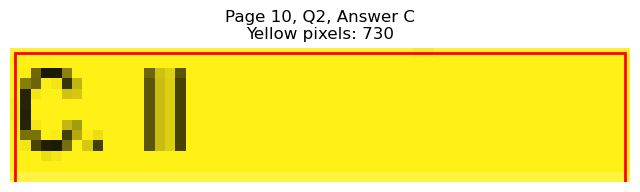

Page 10, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=338.6, y1=190.4
Page 10, Q2, D: Yellow pixels: 62
Page 10, Q2, D: Total non-white pixels: 104
Page 10, Q2, D: Yellow percentage: 59.6%


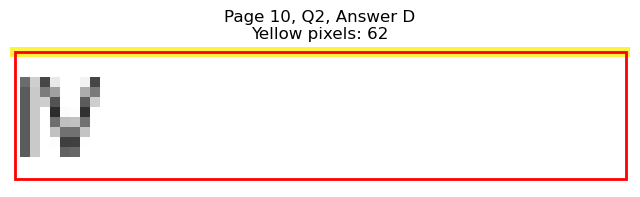


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=141.0, y1=266.1
Page 10, Q3, A: Yellow pixels: 124
Page 10, Q3, A: Total non-white pixels: 462
Page 10, Q3, A: Yellow percentage: 26.8%


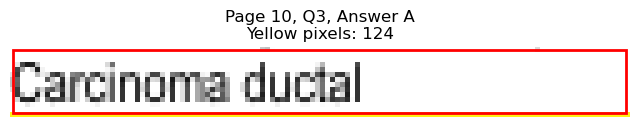

Page 10, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=152.5, y1=278.7
Page 10, Q3, B: Yellow pixels: 1407
Page 10, Q3, B: Total non-white pixels: 1755
Page 10, Q3, B: Yellow percentage: 80.2%


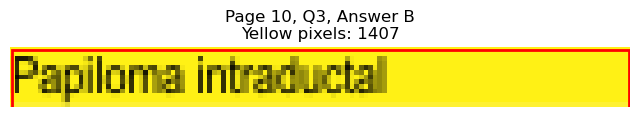

Page 10, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=386.2, y1=266.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 304
Page 10, Q3, C: Yellow percentage: 0.0%


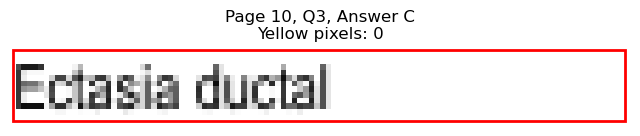

Page 10, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=425.8, y1=278.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 526
Page 10, Q3, D: Yellow percentage: 0.0%


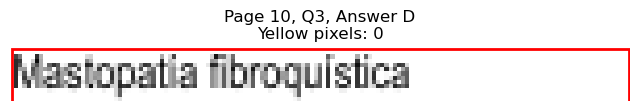


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=56.6, y0=165.1, x1=65.2, y1=177.8
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 43
Page 10, Q4, A: Yellow percentage: 0.0%


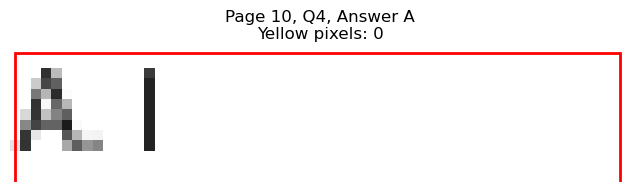

Page 10, Q4 - B: Detected box: x0=68.3, y0=177.7, x1=78.4, y1=190.4
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 32
Page 10, Q4, B: Yellow percentage: 0.0%


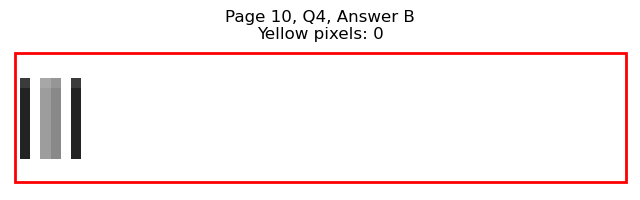

Page 10, Q4 - C: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 10, Q4, C: Yellow pixels: 730
Page 10, Q4, C: Total non-white pixels: 780
Page 10, Q4, C: Yellow percentage: 93.6%


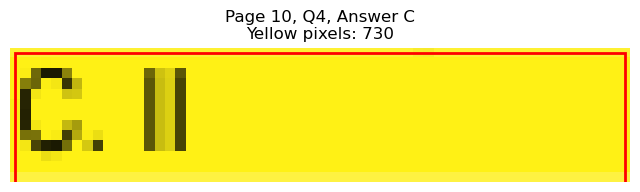

Page 10, Q4 - D: Detected box: x0=327.5, y0=177.7, x1=338.6, y1=190.4
Page 10, Q4, D: Yellow pixels: 62
Page 10, Q4, D: Total non-white pixels: 104
Page 10, Q4, D: Yellow percentage: 59.6%


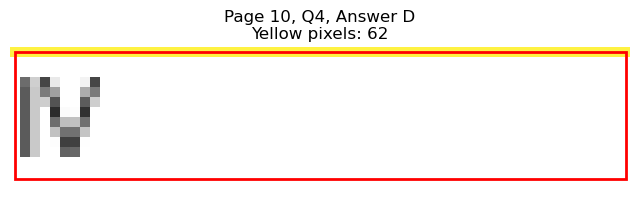


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=160.6, y1=392.4
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 486
Page 10, Q5, A: Yellow percentage: 0.0%


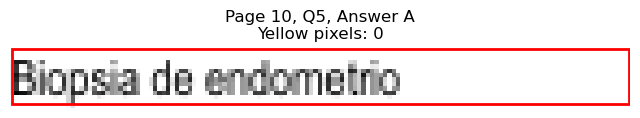

Page 10, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=134.1, y1=405.0
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 310
Page 10, Q5, B: Yellow percentage: 0.0%


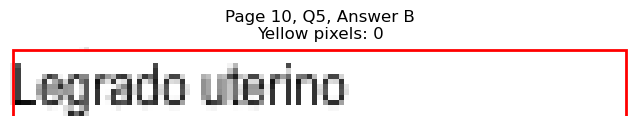

Page 10, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=380.7, y1=392.4
Page 10, Q5, C: Yellow pixels: 1046
Page 10, Q5, C: Total non-white pixels: 1456
Page 10, Q5, C: Yellow percentage: 71.8%


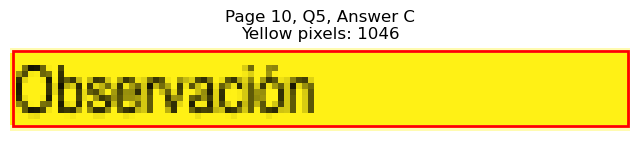

Page 10, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=385.3, y1=405.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 408
Page 10, Q5, D: Yellow percentage: 0.0%


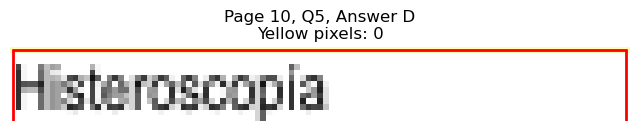


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=146.5, y1=455.5
Page 10, Q6, A: Yellow pixels: 1378
Page 10, Q6, A: Total non-white pixels: 1806
Page 10, Q6, A: Yellow percentage: 76.3%


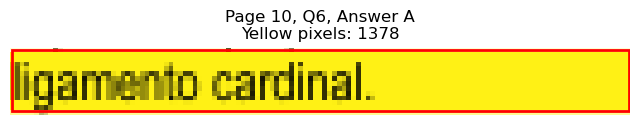

Page 10, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=117.5, y1=468.1
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 259
Page 10, Q6, B: Yellow percentage: 0.0%


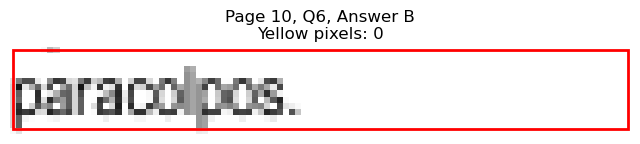

Page 10, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=452.9, y1=455.5
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 641
Page 10, Q6, C: Yellow percentage: 0.0%


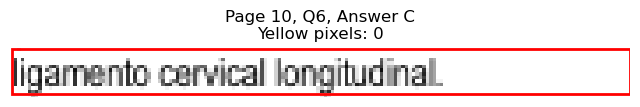

Page 10, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=419.3, y1=468.1
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 429
Page 10, Q6, D: Yellow percentage: 0.0%


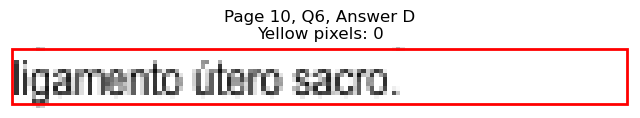


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=166.1, y1=543.8
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 525
Page 10, Q7, A: Yellow percentage: 0.0%


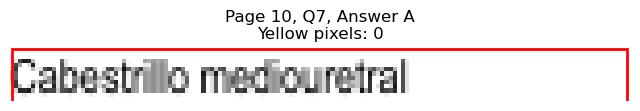

Page 10, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=233.3, y1=556.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 798
Page 10, Q7, B: Yellow percentage: 0.0%


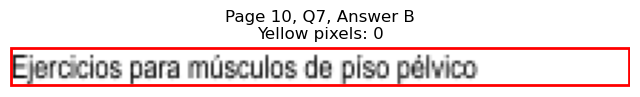

Page 10, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=436.4, y1=543.8
Page 10, Q7, C: Yellow pixels: 1659
Page 10, Q7, C: Total non-white pixels: 2080
Page 10, Q7, C: Yellow percentage: 79.8%


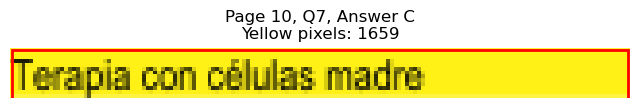

Page 10, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=433.4, y1=556.4
Page 10, Q7, D: Yellow pixels: 156
Page 10, Q7, D: Total non-white pixels: 706
Page 10, Q7, D: Yellow percentage: 22.1%


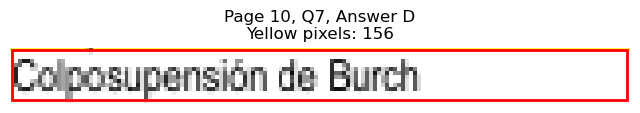


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=112.5, y1=632.3
Page 10, Q8, A: Yellow pixels: 95
Page 10, Q8, A: Total non-white pixels: 346
Page 10, Q8, A: Yellow percentage: 27.5%


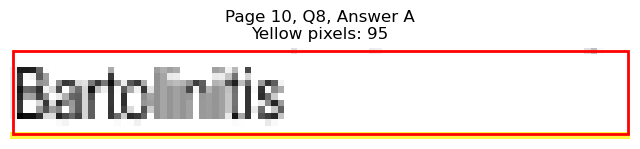

Page 10, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=206.3, y1=644.9
Page 10, Q8, B: Yellow pixels: 1895
Page 10, Q8, B: Total non-white pixels: 2457
Page 10, Q8, B: Yellow percentage: 77.1%


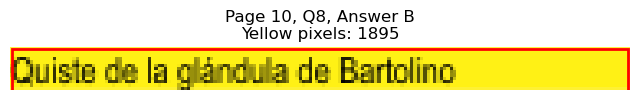

Page 10, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=474.1, y1=632.3
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 738
Page 10, Q8, C: Yellow percentage: 0.0%


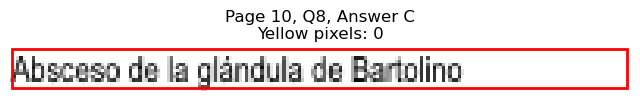

Page 10, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=507.1, y1=644.9
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 901
Page 10, Q8, D: Yellow percentage: 0.0%


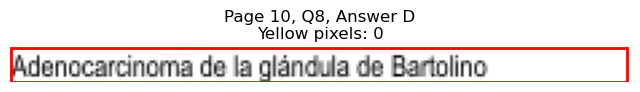


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=146.5, y1=695.3
Page 10, Q9, A: Yellow pixels: 1216
Page 10, Q9, A: Total non-white pixels: 1806
Page 10, Q9, A: Yellow percentage: 67.3%


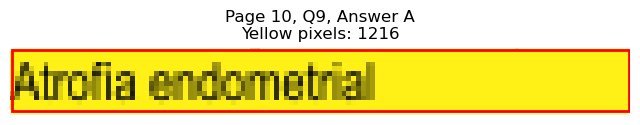

Page 10, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=160.1, y1=708.0
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 576
Page 10, Q9, B: Yellow percentage: 0.0%


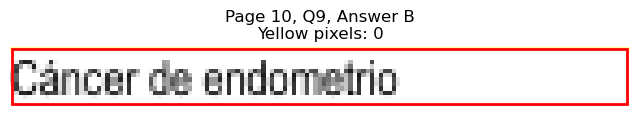

Page 10, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=404.8, y1=695.3
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 397
Page 10, Q9, C: Yellow percentage: 0.0%


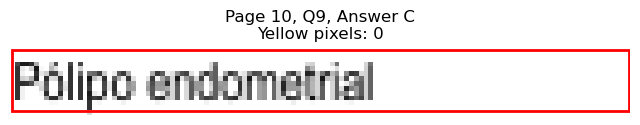

Page 10, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=424.9, y1=708.0
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 540
Page 10, Q9, D: Yellow percentage: 0.0%


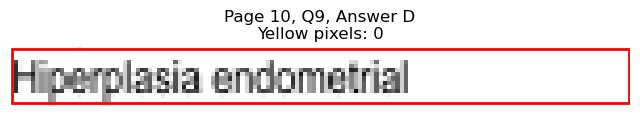


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)





Page 11: Found 3 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=121.5, y1=127.3
Page 11, Q1, A: Yellow pixels: 104
Page 11, Q1, A: Total non-white pixels: 379
Page 11, Q1, A: Yellow percentage: 27.4%


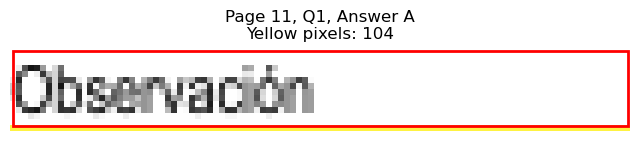

Page 11, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=116.9, y1=139.9
Page 11, Q1, B: Yellow pixels: 1106
Page 11, Q1, B: Total non-white pixels: 1287
Page 11, Q1, B: Yellow percentage: 85.9%


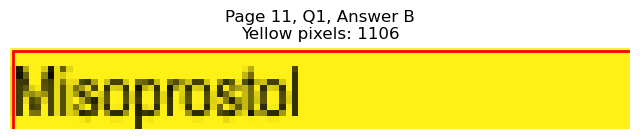

Page 11, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=393.3, y1=127.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 313
Page 11, Q1, C: Yellow percentage: 0.0%


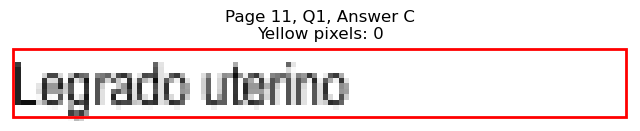

Page 11, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=356.1, y1=139.9
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 150
Page 11, Q1, D: Yellow percentage: 0.0%


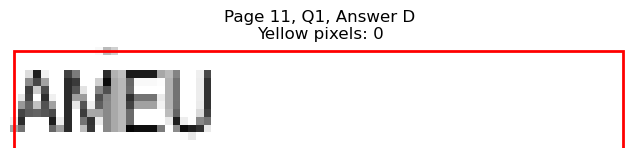


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=206.2, y1=190.4
Page 11, Q2, A: Yellow pixels: 189
Page 11, Q2, A: Total non-white pixels: 894
Page 11, Q2, A: Yellow percentage: 21.1%


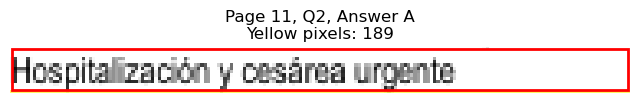

Page 11, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=293.4, y1=203.0
Page 11, Q2, B: Yellow pixels: 2755
Page 11, Q2, B: Total non-white pixels: 3588
Page 11, Q2, B: Yellow percentage: 76.8%


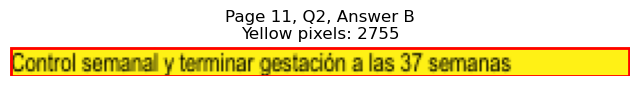

Page 11, Q2 - C: Detected box: x0=68.8, y0=202.9, x1=215.7, y1=215.6
Page 11, Q2, C: Yellow pixels: 192
Page 11, Q2, C: Total non-white pixels: 887
Page 11, Q2, C: Yellow percentage: 21.6%


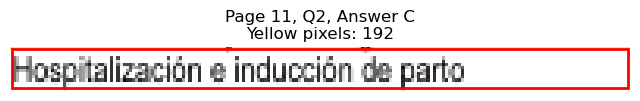

Page 11, Q2 - D: Detected box: x0=68.8, y0=215.7, x1=301.5, y1=228.3
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 1122
Page 11, Q2, D: Yellow percentage: 0.0%


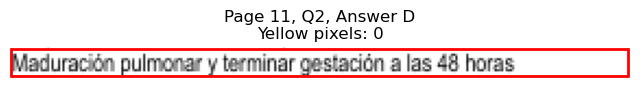


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=147.0, y1=266.1
Page 11, Q3, A: Yellow pixels: 1369
Page 11, Q3, A: Total non-white pixels: 1820
Page 11, Q3, A: Yellow percentage: 75.2%


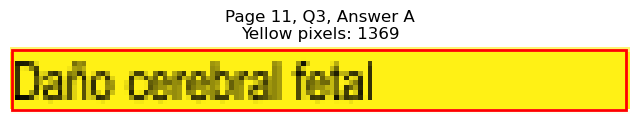

Page 11, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=162.1, y1=278.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 619
Page 11, Q3, B: Yellow percentage: 0.0%


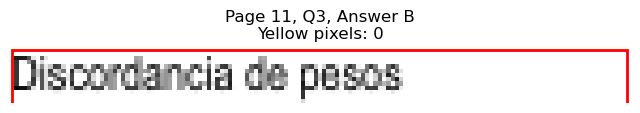

Page 11, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=393.3, y1=266.1
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 345
Page 11, Q3, C: Yellow percentage: 0.0%


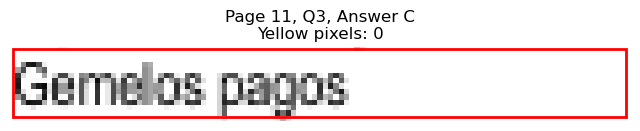

Page 11, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=398.2, y1=278.7
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 359
Page 11, Q3, D: Yellow percentage: 0.0%


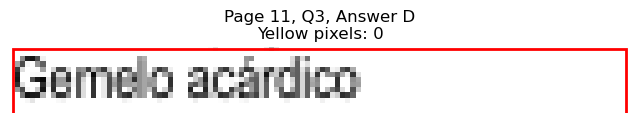


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 30 años, G1 P1001, quién acude por pr...
1   Mujer de 25 años, asintomática, con dos ecogra...
2   Gestante de 38 semanas en fase activa de traba...
3   ¿Cuál es un factor pronóstico de baja recurren...
4   La arteria pudenda interna brinda el principal...
..                                                ...
95  Mujer de 35 años, sin antecedentes patológicos...
96  Mujer de 65 años, refiere sangrado genital esc...
97  Mujer de 26 años, acude por sangrado vaginal e...
98  Gestante de 34 semanas asintomática, acude a e...
99  En el síndrome de transfusión feto fetal, prod...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                  Miomectomía abierta   
1                Error del ecografista   
2                       Espina ciática   
3   Presencia de receptores hormonales   
4                               aorta.   
..                                 ...   
95                        Bartolinitis   
96                 Atrofia endometrial   
97                         Observación   
98   Hospitalización y cesárea urgente   
99                 Daño cerebral fetal   

                                             option_B  \
0                           Miomectomía laparoscópica   
1                                  Gemelo evanescente   
2                                  Ligamento cardinal   
3                    Presencia de tumores aneuploides   
4                                            uterina.   
..                                                ...   
95                 Quiste de la glándula de Bartolino   
96                               Cáncer de endometrio   
97                                        Misoprostol   
98  Control semanal y terminar gestación a las 37 ...   
99                              Discordancia de pesos   

                                option_C  \
0            Histerectomía laparoscópica   
1                        Gemelo atascado   
2                            Hueso coxis   
3                         Tumor de 30 mm   
4                          iliaca común.   
..                                   ...   
95   Absceso de la glándula de Bartolino   
96                    Pólipo endometrial   
97                       Legrado uterino   
98  Hospitalización e inducción de parto   
99                         Gemelos pagos   

                                             option_D  
0                          Miomectomía histeroscópica  
1                                     Gemelo acárdico  
2                               Punto medio del sacro  
3             Expresión elevada del Oncogen HER-2/neu  
4                                     iliaca interna.  
..                                                ...  
95         Adenocarcinoma de la glándula de Bartolino  
96                            Hiperplasia endometrial  
97                                               AMEU  
98  Maduración pulmonar y terminar gestación a las...  
99                                    Gemelo acárdico  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Mujer de 30 años, G1 P1001, quién acude por pr...   
1   Mujer de 25 años, asintomática, con dos ecogra...   
2   Gestante de 38 semanas en fase activa de traba...   
3   ¿Cuál es un factor pronóstico de baja recurren...   
4   La arteria pudenda interna brinda el principal...   
..                                                ...   
95  Mujer de 35 años, sin antecedentes patológicos...   
96  Mujer de 65 años, refiere sangrado genital esc...   
97  Mujer de 26 años, acude por sangrado vaginal e...   
98  Gestante de 34 semanas asintomática, acude a e...   
99  En el síndrome de transfusión feto fetal, prod...   

                              option_A  \
0                  Miomectomía abierta   
1                Error del ecografista   
2                       Espina ciática   
3   Presencia de receptores hormonales   
4                               aorta.   
..                                 ...   
95                        Bartolinitis   
96                 Atrofia endometrial   
97                         Observación   
98   Hospitalización y cesárea urgente   
99                 Daño cerebral fetal   

                                             option_B  \
0                           Miomectomía laparoscópica   
1                                  Gemelo evanescente   
2                                  Ligamento cardinal   
3                    Presencia de tumores aneuploides   
4                                            uterina.   
..                                                ...   
95                 Quiste de la glándula de Bartolino   
96                               Cáncer de endometrio   
97                                        Misoprostol   
98  Control semanal y terminar gestación a las 37 ...   
99                              Discordancia de pesos   

                                option_C  \
0            Histerectomía laparoscópica   
1                        Gemelo atascado   
2                            Hueso coxis   
3                         Tumor de 30 mm   
4                          iliaca común.   
..                                   ...   
95   Absceso de la glándula de Bartolino   
96                    Pólipo endometrial   
97                       Legrado uterino   
98  Hospitalización e inducción de parto   
99                         Gemelos pagos   

                                             option_D correct_answer  
0                          Miomectomía histeroscópica              B  
1                                     Gemelo acárdico              B  
2                               Punto medio del sacro              A  
3             Expresión elevada del Oncogen HER-2/neu              A  
4                                     iliaca interna.              D  
..                                                ...            ...  
95         Adenocarcinoma de la glándula de Bartolino              B  
96                            Hiperplasia endometrial              A  
97                                               AMEU              B  
98  Maduración pulmonar y terminar gestación a las...              B  
99                                    Gemelo acárdico              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/GINECOLOGÍA.csv
